# Multimodal Survival Prediction in Glioma: Integrating MRI Imaging and Clinical Data Using Convolutional Neural Networks
<div id='content'></div>

Qianwen Li, Ninghui Hao, Shuhua Xu, Taiyang Chen

<a id="contents"></a>
## Table of content
- [**Part 1. Motivation, context, and framing of the problem**](#part1)
    - [Project Introduction](#intro)
    - [Motivation and Problem Statement](#motivation)
- [**Part 2. Description of the data**](#part2)
    - [Clinical data](#clinic)
    - [MRI image data](#image)
- [**Part 3. Feature Engineering and Comprehensive EDA Review**](#part3)
    - [Clinical data](#clinic_eda)
    - [MRI image data](#image_eda)
- [**Part 4. Baseline models and result assessment**](#part4)
    - [2D CNN baseline model](#2dcnn)
    - [Transfer Learning](#transfer)
    - [Classifier for clinical data](#classifier_clinic)
    - [Transfer learning with clinical data](#transfer_clinic)
    - [Autoencoder](#autoencoder)
    - [3D CNN Selection and Justification](#3dcnn)
    - [3D CNN without the black regions](#3dcnn_new)
- [**Part 5. Final Model and discussion**](#part5)
    - [Flow Chart of our model](#flow_chart)
    - [Steps for our final model](#steps)
    - [Conclusion](#conclusion)
    - [Discussion](#discussion)

## Part 1. Motivation, context, and framing of the problem <div id='part1'></div>

### Project Introduction <div id='intro'>

Enhancing survival prediction methodologies in brain cancer research is crucial for improving cancer treatment outcomes, especially for aggressive tumors like glioblastoma. Despite significant advancements in medical science, brain tumors remain challenging to treat, with survival rates that are difficult to improve. The emergence of artificial intelligence (AI) offers a novel opportunity for substantial breakthroughs.

Traditional survival prediction methods rely primarily on clinical data, providing only a partial view of patient prognosis. MRI images offer a comprehensive representation of tumor features essential for understanding prognosis. Our project aims to utilize convolutional neural networks (CNNs) and potentially other deep learning models to analyze MRI scans of brain tumor patients. By leveraging CNNs' excellence in image analysis, we aim to identify complex patterns within MRI images predictive of survival outcomes.

We will utilize the University of California San Francisco Preoperative Diffuse Glioma MRI (UCSF-PDGM) dataset, which includes 495 subjects with histopathologically-proven diffuse gliomas. The dataset features standardized 3 Tesla preoperative brain tumor MRI scans with advanced imaging techniques. The MRI images are pre-processed, skull-stripped, and segmented to focus on tumor regions, facilitating model analysis. Additionally, the dataset includes clinical data such as age, gender, tumor grade, and genetic markers.

Our approach adopts a multimodal strategy, integrating detailed MRI image data with traditional clinical data. This integration enables comprehensive analysis by combining visual insights from MRIs with quantitative and qualitative clinical metrics. The incorporation of diverse data sources, including age, gender, tumor grade, and genetic markers, enhances the accuracy and reliability of survival predictions in brain cancer patients.

### Motivation and Problem statement <div id='motivation'>

Our goal is to predict the survival status (dead or alive) of patients at last clinical follow up. We will achieve this goal by utilizing MRI image data and clinical data to train a CNN-based neural network. Our project aims to answer the following three questions:

- ##### 1. Model Structure: In which way can we utilize the clinical and image data to predict patients' survival?

- ##### 2. Computational Optimization: Based on the complex nature of the 3D MRI data and the limited computational resource, what kind of image data should we implement and what preprocessing steps are needed to facilitate training process?

- ##### 3. Result Evaluation: How well can our models perform? Does a complex, 3D-CNN model yield better results than a simple, 2D-CNN model? Does combining clinical and image data yield better results than only using clinical or image data?

[back](#content)

## Part 2. Description of the data <div id='part2'>

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns
import re
import keras
import tensorflow as tf 
from keras import layers
import nilearn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from sklearn.preprocessing import StandardScaler

import os
import pathlib
import zipfile
import tarfile

import imageio
from matplotlib import cm
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import cv2

%matplotlib inline
# RUN THIS CELL

working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)

# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



#### Clinical data <div id='clinic'></div>
**Dataset inspectation**

Going through the descirption of clinical dataset and the metadata itself, we only include Sex, Age, WHO CNS grade, Final Pathologic diagnosis, MGMT status, MGMT index, 1p/19q, IDH and EOR as features for training and testing, among which most of features are categorical excluding Age and MGMT index as continuous values. They are associated with demographic and epigenetic characteristics of patients. Detailed descriptions of each features are shown in the following figure.

**Meaning of the features**
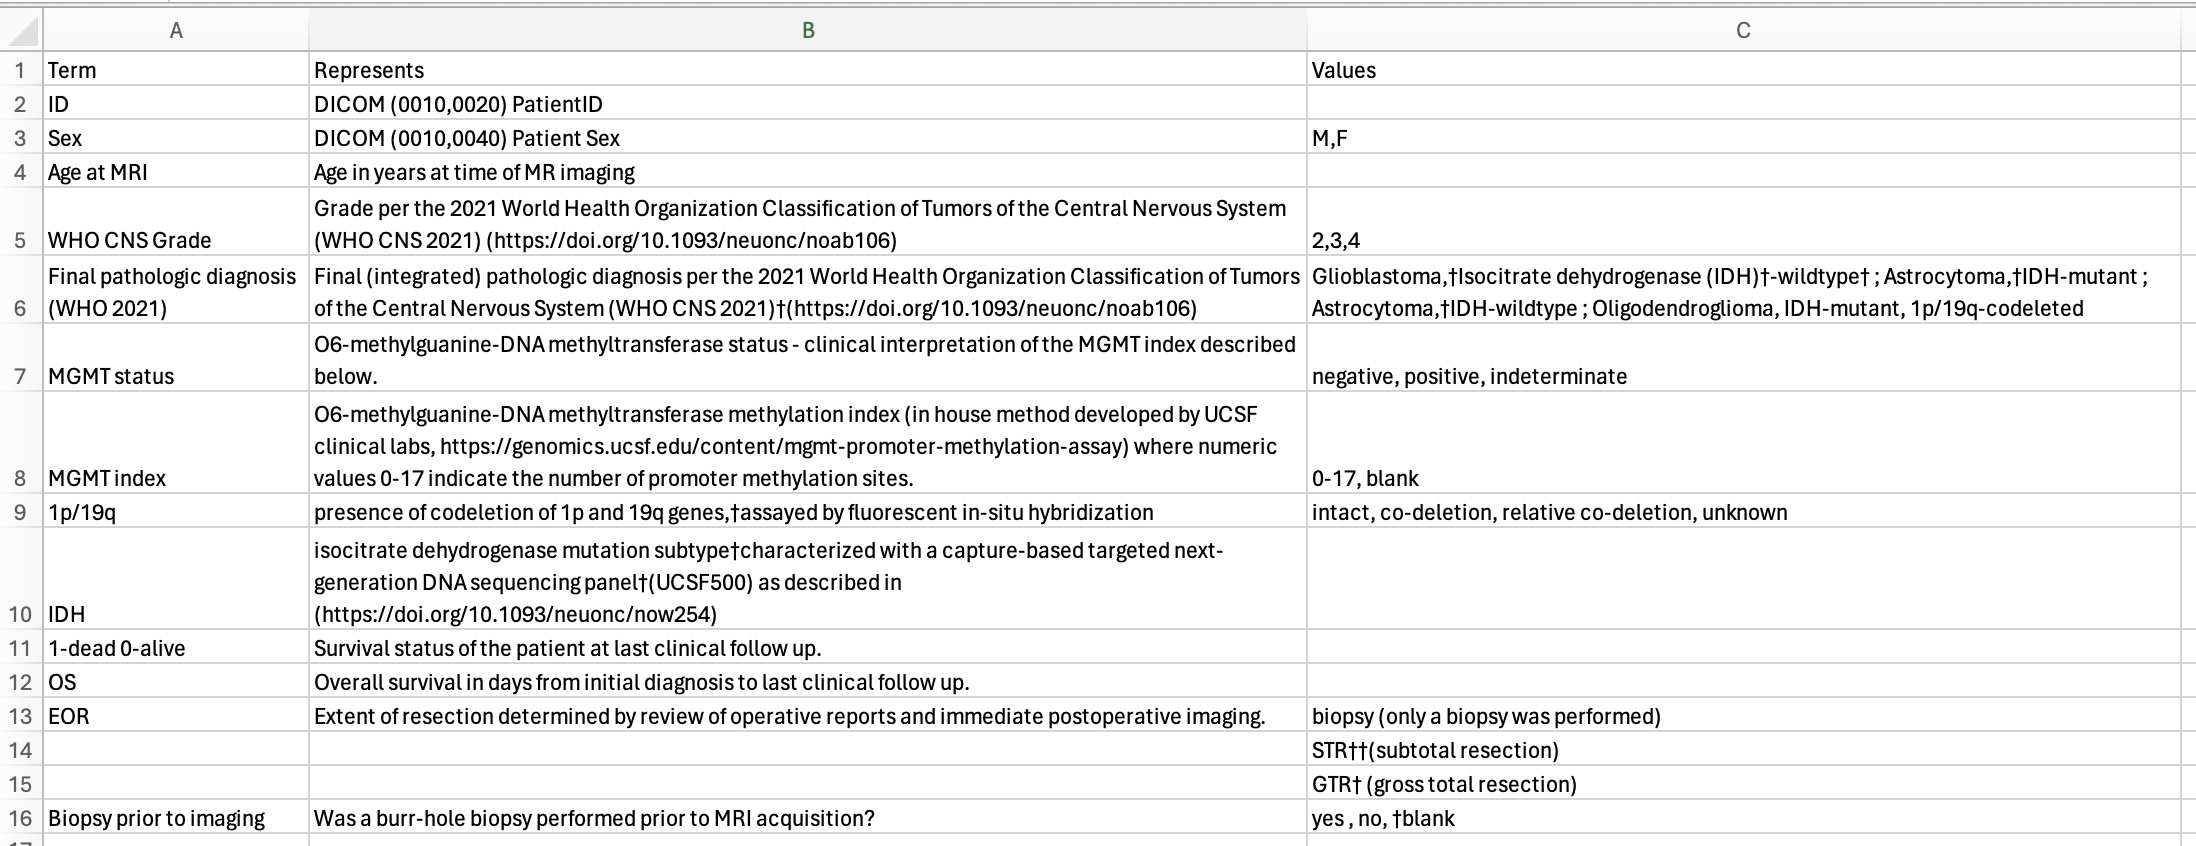

In [2]:
descri = pd.read_csv("cs109b_clinical_data/UCSF-PDGM-metadata_glossary.csv")
meta_pdgm_clinic = pd.read_csv("cs109b_clinical_data/UCSF-PDGM-metadata_v2.csv")
print(meta_pdgm_clinic.shape)
meta_pdgm_clinic.head()

(501, 16)


ID Sex  Age at MRI  WHO CNS Grade  \
0  UCSF-PDGM-004   M          66              4   
1  UCSF-PDGM-005   F          80              4   
2  UCSF-PDGM-007   M          70              4   
3  UCSF-PDGM-008   M          70              4   
4  UCSF-PDGM-009   F          68              4   

  Final pathologic diagnosis (WHO 2021)    MGMT status  MGMT index 1p/19q  \
0            Glioblastoma, IDH-wildtype       negative         0.0    NaN   
1            Glioblastoma, IDH-wildtype  indeterminate         NaN    NaN   
2            Glioblastoma, IDH-wildtype  indeterminate         NaN    NaN   
3            Glioblastoma, IDH-wildtype       negative         0.0    NaN   
4            Glioblastoma, IDH-wildtype       negative         0.0    NaN   

        IDH  1-dead 0-alive      OS     EOR Biopsy prior to imaging  \
0  wildtype               1  1303.0     STR                      No   
1  wildtype               1   274.0  biopsy                      No   
2  wildtype               1   417.0     STR                      No   
3  wildtype               1   185.0     STR                      No   
4  wildtype               1   389.0     STR                      No   

        BraTS21 ID BraTS21 Segmentation Cohort BraTS21 MGMT Cohort  
0  BraTS2021_00097                    Training            Training  
1              NaN                         NaN                 NaN  
2  BraTS2021_00103                    Training                 NaN  
3              NaN                         NaN                 NaN  
4  BraTS2021_00049                    Training            Training

In [3]:
### Check NAN value for each feature
meta_pdgm_clinic.isna().sum()

ID                                         0
Sex                                        0
Age at MRI                                 0
WHO CNS Grade                              0
Final pathologic diagnosis (WHO 2021)      0
MGMT status                               80
MGMT index                                88
1p/19q                                    91
IDH                                        0
1-dead 0-alive                             0
OS                                         1
EOR                                        1
Biopsy prior to imaging                    0
BraTS21 ID                               203
BraTS21 Segmentation Cohort              203
BraTS21 MGMT Cohort                      218
dtype: int64

In [4]:
## convert values in the 1p/19q column to lower case
meta_pdgm_clinic['1p/19q'] = meta_pdgm_clinic['1p/19q'].str.lower()

We encoded the categorical features into numbers, and performed train test splitting using a test size of 0.2. One-hot encoding was performed in later steps.

In [5]:
### Training and testing dataset split

## Category features
le = LabelEncoder()
col_to_encode = ['Sex', 'WHO CNS Grade', 'MGMT status','Final pathologic diagnosis (WHO 2021)', '1p/19q', 'IDH','EOR']
X_meta_pdgm_clinic = meta_pdgm_clinic[col_to_encode]

params_dict = {}

for i, col in enumerate(col_to_encode):
    X_meta_pdgm_clinic.loc[:,col] = le.fit_transform(meta_pdgm_clinic[col])
    encode_dict = {}
    for j, classes in enumerate(le.classes_):
        encode_dict[j] = classes
    params_dict[col] = encode_dict
X_meta_pdgm_clinic['ID'] = meta_pdgm_clinic['ID']

## Reset NaN in 'MGMT status' column
X_meta_pdgm_clinic.loc[meta_pdgm_clinic['MGMT status'].isnull(), 'MGMT status'] = np.NaN
X_meta_pdgm_clinic.loc[meta_pdgm_clinic['MGMT index']>0, 'MGMT status'] = 2
X_meta_pdgm_clinic.loc[meta_pdgm_clinic['MGMT index']==0, 'MGMT status'] = 1
X_meta_pdgm_clinic.loc[meta_pdgm_clinic['MGMT status']=='negative', 'MGMT index'] = 0


## Continuous features
X_meta_pdgm_clinic.loc[:,['Age at MRI','MGMT index']] = meta_pdgm_clinic[['Age at MRI','MGMT index']].astype('float32')
y_meta_pdgm_clinic = meta_pdgm_clinic['1-dead 0-alive'].astype('category')
X_meta_pdgm_clinic.info()


X_train, X_test, y_train, y_test = train_test_split(X_meta_pdgm_clinic, y_meta_pdgm_clinic, test_size=0.2, random_state=12)
#train size ~400, test size ~100
y_meta_pdgm_clinic['ID'] = meta_pdgm_clinic['ID']
sum(y_meta_pdgm_clinic.isnull())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Sex                                    501 non-null    object 
 1   WHO CNS Grade                          501 non-null    int64  
 2   MGMT status                            422 non-null    object 
 3   Final pathologic diagnosis (WHO 2021)  501 non-null    object 
 4   1p/19q                                 501 non-null    object 
 5   IDH                                    501 non-null    object 
 6   EOR                                    501 non-null    object 
 7   ID                                     501 non-null    object 
 8   MGMT index                             413 non-null    float64
 9   Age at MRI                             501 non-null    float32
dtypes: float32(1), float64(1), int64(1), object(7)
memory usage: 37.3+ KB


/var/folders/xy/wvr18bx918l5m6z2vsgxtfw80000gn/T/ipykernel_83252/2751980334.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_meta_pdgm_clinic['ID'] = meta_pdgm_clinic['ID']
/var/folders/xy/wvr18bx918l5m6z2vsgxtfw80000gn/T/ipykernel_83252/2751980334.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_meta_pdgm_clinic.loc[meta_pdgm_clinic['MGMT status']=='negative', 'MGMT index'] = 0


0

Here we encoded each categorical feature into numerical labels. The following parameter dictionary shows the corresponding meaning for each encoded categorical variable in X data. We reset MGMT status = 3 (nan) as nan.

The outcome y (survival) is binary (1=dead, 0=alive), and is encoded as integers.

In [6]:
params_dict

{'Sex': {0: 'F', 1: 'M'},
 'WHO CNS Grade': {0: 2, 1: 3, 2: 4},
 'MGMT status': {0: 'indeterminate', 1: 'negative', 2: 'positive', 3: nan},
 'Final pathologic diagnosis (WHO 2021)': {0: 'Astrocytoma, IDH-mutant',
  1: 'Astrocytoma, IDH-wildtype',
  2: 'Glioblastoma, IDH-wildtype',
  3: 'Oligodendroglioma, IDH-mutant, 1p/19q-codeleted'},
 '1p/19q': {0: 'co-deletion', 1: 'intact', 2: 'relative co-deletion', 3: nan},
 'IDH': {0: 'IDH1 p.Arg132His',
  1: 'IDH1 p.R132C',
  2: 'IDH1 p.R132G',
  3: 'IDH1 p.R132H',
  4: 'IDH1 p.R132S',
  5: 'IDH2 p.Arg172Trp',
  6: 'IDH2 p.R172K',
  7: 'mutated (NOS)',
  8: 'wildtype'},
 'EOR': {0: 'GTR', 1: 'STR', 2: 'biopsy', 3: nan}}

#### MRI Image data <div id='image'></div>

**Dataset Description**

The image data contains brain images of 495 patients and for each patient, there are 23 or 47 three-dimensional images from different magnetic resonance imaging (MRI) sequences. 489 of these patients were imaged once and 6 patients were imaged twice. There is no missing image. Considering the computing capacity of the course GPU, we select images from the following 5 MRI techniques which have been commonly used in brain imaging : T1-weighted (T1), T1-weighted postcontrast (T1c), T2-weighted (T2), fluid-attenuated inversion recovery (FLAIR), arterial spin labeling perfusion (ASL).

In [10]:
# Examine the image dataset
df = pd.read_csv("UCSF-PDGM-v3.sums", header=None,sep=' ') # a list of image file names
df.rename(columns={0: 'col1', 1: 'file_name'}, inplace=True)
df = df.drop(columns=['col1'])

patient_id = np.array(["{:04d}".format(i) for i in range(4, 542)]) # patient ID from the dataset website
n_images = []
for i in patient_id:
  n_images.append(df['file_name'].str.contains(i).sum())
n_images = np.array(n_images)

# 0: the patient ID does not exist
print(str(np.sum(n_images==23)) + " patients were imaged once") # 23: the patient was imaged once
print(str(np.sum(n_images==47)) + " patients were imaged twice") # 47: the patient was imaged twice

489 patients were imaged once
6 patients were imaged twice


In [11]:
patient_id = patient_id[n_images != 0]
image_type = ["T1", "T1c", "T2", "FLAIR", "ASL"]

The dimension of each image is $240 \times 240 \times 155$. Here we display the images along the three dimensions.

In [12]:
def read_image(patient_id, image_type):

  file_name = f"cs109b_image_data/UCSF-PDGM-{patient_id}_{image_type}.nii.gz"
  img_load = nib.load(file_name).get_fdata()

  return img_load

In [13]:
# the dimension of one 3D image
test_load = read_image(patient_id[0], image_type[0])
test_load.shape

(240, 240, 155)

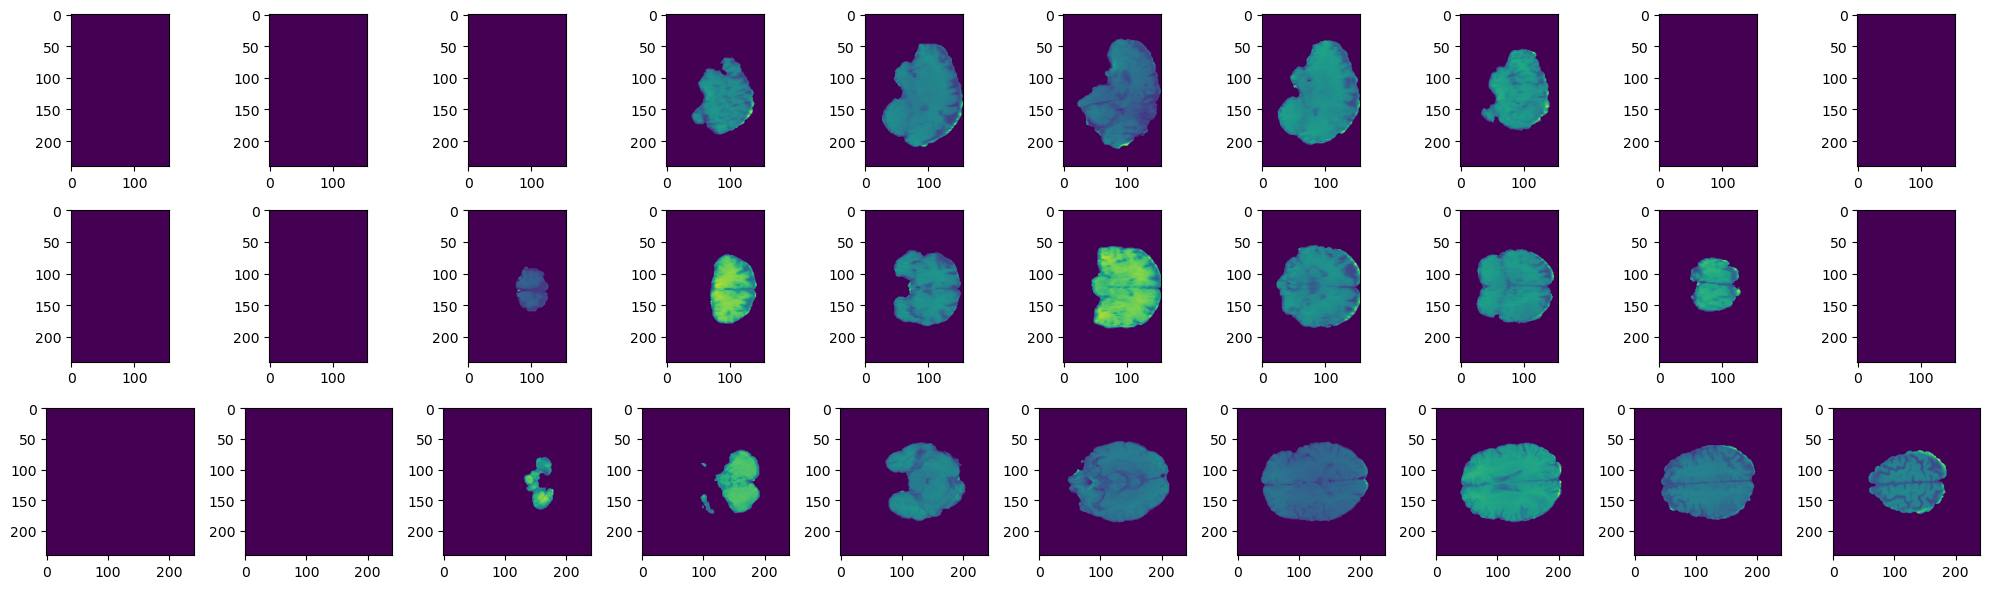

In [14]:
# the images along the three dimensions
fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))

for i in range(10):

  # the first dimension
  test_img = test_load[24*i,:,:]
  axs[0][i].imshow(test_img)

  # the second dimension
  test_img = test_load[:,24*i,:]
  axs[1][i].imshow(test_img)

  # the third dimension
  test_img = test_load[:,:,15*i]
  axs[2][i].imshow(test_img)

plt.tight_layout()

plt.show()

Here we show the images from the first 10 patients. Each row is one type of image from a MRI technique and each column is a patient.

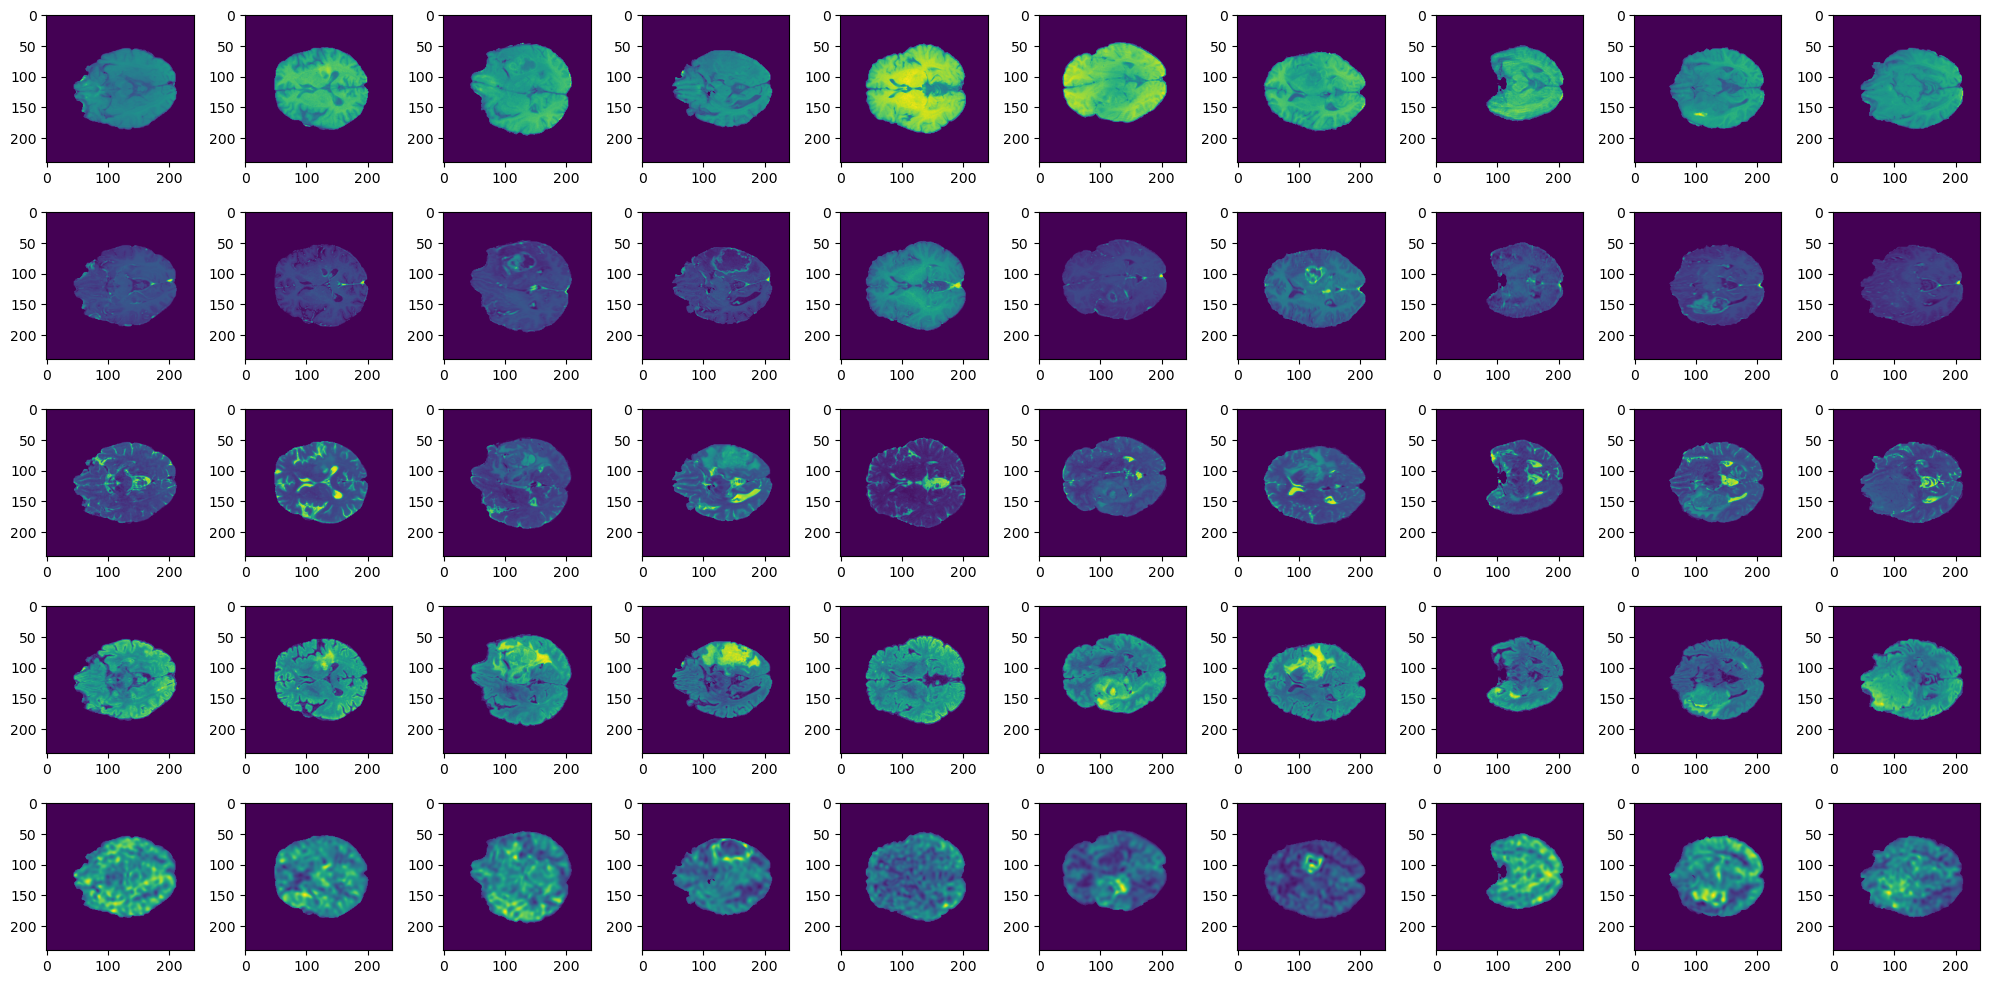

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))

for i in range(5):
  for j in range(10):

    image_data = read_image(patient_id[j], image_type[i])
    image_data = image_data[:,:,77]
    axs[i][j].imshow(image_data)

plt.tight_layout()

plt.show()

[back](#content)

## Part 3. Feature Engineering and Comprehensive EDA Review <div id='part3'>


### Clinical Data <div id='clinic_eda'></div>

**Missing value processing**

- Missing value in EOR

There is only one missing value in EOR. Since the missing rate is small, we can drop the observation from X_test (n=1).

- Missing value in 1p/19q

From the description, we know that the NaN in the column '1p/19q' refers to the unknown presence of co-deletion of 1p and 19q genes, which could be considered as a category. So transfering labels using LabelEncoder() will automatively convert NaN to a category denoted by 3.

- Missing value in MGMT index

From manual inspectation, we know that MGMT status = negative is associated with MGMT index = 0, and when MGMT index >0, MGMT status should be positive. If MGMT status is indeterminate, MGMT index should be NaN. Thus, we firstly fill several observations based on these rules (in total n=2). Afterwards, because these missing value are 'Missing Not at Random (MNAR)' and the size of our dataset is relatively small, we decide to use kNN imputation to fulfill missing values in `MGMT status` and `MGMT index`. However, if MGMT status is indeterminate, it is unreasonable to assign these observations a `MGMT index`. Together with a limited numebr of 'MGMT status == indeterminate', we will drop observations after kNN imputation (n=3 for training data and n=2 for testing data). 

After imputation, all X data are floating numbers, but in fact only `Age at MRI` and `MGMT index` are continous variables (`MGMT index` are ordinal integers, ranging from 0 to 17; we accept decimals after imputation.

**Notes:**

We did not impute the floating numbers into missing categorical variables except `MGMT status` since this kind of imputation does not make sense. Instead, we encoded them into a separate category representing missing values. We imputed `MGMT status` because this is actually a binary variable, and a value between 1 and 2 represents how likely the patient is to be negative or positive.

In [7]:
### Missing value in MGMT index, MGMT status
## Missing not at random, to perform kNN imputation
imputer = KNNImputer(n_neighbors=10, weights="uniform")

imp_X_train = imputer.fit_transform(X_train.drop(['ID'],axis=1))
imp_X_test = imputer.fit_transform(X_test.drop(['ID'],axis=1))

imputed_X_train = pd.DataFrame(imp_X_train, columns=X_train.columns.drop('ID'),index=X_train.index)
imputed_X_test = pd.DataFrame(imp_X_test, columns=X_test.columns.drop('ID'), index = X_test.index)

dropidx_train = imputed_X_train.index[imputed_X_train['MGMT status'] == 0].tolist()
dropidx_test = imputed_X_test.index[(imputed_X_test['MGMT status'] == 0) | (imputed_X_test['EOR'] == 3)].tolist()

## Drop observations with MGMT status = indeterminated (0) or EOR = missing (3)
imputed_X_train.drop(dropidx_train,inplace=True)
imputed_X_test.drop(dropidx_test,inplace=True)
X_train.drop(dropidx_train,inplace=True)
X_test.drop(dropidx_test,inplace=True)
imputed_X_train['ID'] = X_train['ID']
imputed_X_test['ID'] = X_test['ID']
imputed_y_train = y_train.drop(dropidx_train)
imputed_y_test = y_test.drop(dropidx_test)
print(imputed_X_train.shape,len(imputed_y_train),imputed_X_test.shape,len(imputed_y_test))
print(imputed_X_train.info(),imputed_X_test.info())

(397, 10) 397 (98, 10) 98
<class 'pandas.core.frame.DataFrame'>
Index: 397 entries, 81 to 331
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Sex                                    397 non-null    float64
 1   WHO CNS Grade                          397 non-null    float64
 2   MGMT status                            397 non-null    float64
 3   Final pathologic diagnosis (WHO 2021)  397 non-null    float64
 4   1p/19q                                 397 non-null    float64
 5   IDH                                    397 non-null    float64
 6   EOR                                    397 non-null    float64
 7   MGMT index                             397 non-null    float64
 8   Age at MRI                             397 non-null    float64
 9   ID                                     397 non-null    object 
dtypes: float64(9), object(1)
memory usage: 34.1+ KB
<cla

**Feature Scaling**

We only perform feature scaling to our continuous variable, `Age at MRI` and `MGMT index`. There is no specific distribution of two variables since they are completely independent in each observation, so we choose to do Min-Max normalization to scale two variables.

In [8]:
### Min-Max scaling

## Age at MRI
a_min_train = imputed_X_train['Age at MRI'].min()
a_max_train = imputed_X_train['Age at MRI'].max()
a_min_test = imputed_X_test['Age at MRI'].min()
a_max_test = imputed_X_test['Age at MRI'].max()

imputed_X_train['Age at MRI'] = (imputed_X_train['Age at MRI'] - a_min_train) / (a_max_train - a_min_train)
imputed_X_test['Age at MRI'] = (imputed_X_test['Age at MRI']-a_min_test) / (a_max_test-a_min_test)

## MGMT index
mgmt_min_tr = imputed_X_train['MGMT index'].min()
mgmt_max_tr = imputed_X_train['MGMT index'].max()
mgmt_min_te = imputed_X_test['MGMT index'].min()
mgmt_max_te = imputed_X_test['MGMT index'].max()

imputed_X_train['MGMT index'] = (imputed_X_train['MGMT index']-mgmt_min_tr) / (mgmt_max_tr-mgmt_min_tr)
imputed_X_test['MGMT index'] = (imputed_X_test['MGMT index']-mgmt_min_te) / (mgmt_max_te-mgmt_min_te)

In [9]:
imputed_X_train.to_csv('cs109b_data_after_preprocess/imputed_scaled_X_train.csv')
imputed_X_test.to_csv('cs109b_data_after_preprocess/imputed_scaled_X_test.csv')
imputed_y_train.to_csv('cs109b_data_after_preprocess/imputed_scaled_y_train.csv')
imputed_y_test.to_csv('cs109b_data_after_preprocess/imputed_scaled_y_test.csv')

In [2]:
# read in clinical data as train and test data
X_train = pd.read_csv('cs109b_data_after_preprocess/imputed_scaled_X_train.csv')
X_test = pd.read_csv('cs109b_data_after_preprocess/imputed_scaled_X_test.csv')
y_train = pd.read_csv('cs109b_data_after_preprocess/imputed_scaled_y_train.csv')
y_test = pd.read_csv('cs109b_data_after_preprocess/imputed_scaled_y_test.csv')

In [3]:
X_train = X_train.drop('Unnamed: 0',axis=1)
X_test = X_test.drop('Unnamed: 0',axis=1)
y_train = y_train.drop('Unnamed: 0',axis=1)
y_test = y_test.drop('Unnamed: 0',axis=1)

In [4]:
# Set patient IDs
X_train['patientID'] = X_train['ID'].str.extract(r'(\d+)')
X_train['patientID'] = X_train['patientID'].str.zfill(4)
X_test['patientID'] = X_test['ID'].str.extract(r'(\d+)')
X_test['patientID'] = X_test['patientID'].str.zfill(4)
X_train.index = X_train['patientID']
X_test.index = X_test['patientID']
y_train.index = X_train['patientID']
y_test.index = X_test['patientID']
X_train = X_train.drop(['patientID','ID'],axis=1)
X_test = X_test.drop(['patientID','ID'],axis=1)

# convert y from dataframe to series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

**Check the correspondence of two datasets**

We check if the corresponding image data exists for each patient recorded with clinical information. If there is no image data, we discard the clinical data. We dropped 6 rows in total.

After manually checking, we find that the discarded data are actually replicates of the same patients that have been recoreded with the clinical data.

Here the image type is 'tumor_segmentation', and the reason for selecting this type will be explained in the image preprocessing part.

In [5]:
train_patient_id = X_train.index
test_patient_id = X_test.index
image_type = ['tumor_segmentation',]

In [6]:
# check if the image data exists for each patient
def check_image_exist(ids, image_type):
    for id in ids:
        # Path to check
        file_name = f"cs109b_image_data/UCSF-PDGM-{id}_{image_type}.nii.gz"
    
        # Check if the path exists
        if not os.path.exists(file_name):
            print(id)


In [33]:
check_image_exist(train_patient_id, image_type[0])

0278
0138
0181
0315
0175


In [34]:
check_image_exist(test_patient_id, image_type[0])

0289


In [7]:
# drop the clinical observations of which the image data do not exist
X_train = X_train.drop(['0278','0138','0181','0315','0175'])
y_train = y_train.drop(['0278','0138','0181','0315','0175'])
X_test = X_test.drop(['0289'])
y_test = y_test.drop(['0289'])

In [8]:
X_train.shape

(392, 9)

In [9]:
X_test.shape

(97, 9)

Finally, after dropping the clinical observations of which the image data do not exist, the sample size of our train data is 392 and the sample size of our test data is 97.

**One Hot Encoding for clinical data**

We applied One-Hot encoding to the multi-variate categorical clinical predictors because the numbers here only represent non-ordinal categories.

In [10]:
print("Unique values in each column of X_train:")
for column in X_train.columns:
    print(f"{column}: {X_train[column].unique()}")

# For X_test
print("\nUnique values in each column of X_test:")
for column in X_test.columns:
    print(f"{column}: {X_test[column].unique()}")

Unique values in each column of X_train:
Sex: [1. 0.]
WHO CNS Grade: [2. 1. 0.]
MGMT status: [2.  1.  1.8 1.9 1.6 1.7 1.5 1.4]
Final pathologic diagnosis (WHO 2021): [2. 0. 3. 1.]
1p/19q: [3. 1. 2. 0.]
IDH: [8. 7. 3. 0. 1. 4. 5. 2.]
EOR: [0. 1. 2.]
MGMT index: [0.70588235 0.05882353 0.         0.76470588 0.64705882 0.49411765
 0.11764706 0.46470588 0.82352941 1.         0.94117647 0.17647059
 0.44117647 0.39411765 0.58823529 0.51764706 0.65294118 0.88235294
 0.35294118 0.57647059 0.34117647 0.67058824 0.6        0.29411765
 0.47647059 0.52941176 0.41176471 0.37647059 0.60588235 0.35882353
 0.21764706 0.23529412 0.20588235 0.21176471 0.55882353 0.25294118
 0.54705882 0.61176471 0.22941176 0.67647059 0.62941176 0.56470588
 0.32941176 0.47058824 0.66470588 0.48235294 0.28823529 0.31176471
 0.50588235 0.45882353 0.45294118 0.63529412 0.42352941 0.52352941
 0.40588235 0.36470588 0.3        0.18823529 0.61764706]
Age at MRI: [0.80519481 0.64935065 0.63636364 0.48051948 0.41558442 0.85714286


In [11]:
from sklearn.preprocessing import OneHotEncoder

## Columns to be one-hot encoded
col_to_encode = ['WHO CNS Grade', 'Final pathologic diagnosis (WHO 2021)', '1p/19q', 'IDH', 'EOR']

## Combine unique values from both train and test sets for each categorical column
all_possible_categories = {col: np.union1d(X_train[col].unique(), X_test[col].unique()) for col in col_to_encode}

## Initialize OneHotEncoder with explicit categories
ohe = OneHotEncoder(categories=[all_possible_categories[col] for col in col_to_encode], sparse_output=False, drop='first')

## Fit and transform
X_train_encoded = ohe.fit_transform(X_train[col_to_encode])
X_test_encoded = ohe.transform(X_test[col_to_encode])

## Convert to DataFrames
X_train_ohe = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(), index=X_test.index)

## Add variables
for col in ['Sex', 'MGMT index', 'Age at MRI', 'MGMT status']:
    X_train_ohe[col] = X_train[col]
    X_test_ohe[col] = X_test[col]

## Adjust the 'MGMT status' to 0, 1
X_train_ohe['MGMT status'] = X_train['MGMT status'] - 1
X_test_ohe['MGMT status'] = X_test['MGMT status'] - 1


In [34]:
X_train_ohe

WHO CNS Grade_1.0  WHO CNS Grade_2.0  \
patientID                                         
0093                     0.0                1.0   
0479                     0.0                1.0   
0004                     0.0                1.0   
0328                     0.0                1.0   
0168                     0.0                1.0   
...                      ...                ...   
0275                     0.0                1.0   
0287                     0.0                1.0   
0431                     0.0                1.0   
0174                     0.0                1.0   
0371                     0.0                1.0   

           Final pathologic diagnosis (WHO 2021)_1.0  \
patientID                                              
0093                                             0.0   
0479                                             0.0   
0004                                             0.0   
0328                                             0.0   
0168                                             0.0   
...                                              ...   
0275                                             0.0   
0287                                             0.0   
0431                                             0.0   
0174                                             0.0   
0371                                             0.0   

           Final pathologic diagnosis (WHO 2021)_2.0  \
patientID                                              
0093                                             1.0   
0479                                             1.0   
0004                                             1.0   
0328                                             1.0   
0168                                             1.0   
...                                              ...   
0275                                             1.0   
0287                                             1.0   
0431                                             1.0   
0174                                             0.0   
0371                                             1.0   

           Final pathologic diagnosis (WHO 2021)_3.0  1p/19q_1.0  1p/19q_2.0  \
patientID                                                                      
0093                                             0.0         0.0         0.0   
0479                                             0.0         1.0         0.0   
0004                                             0.0         0.0         0.0   
0328                                             0.0         1.0         0.0   
0168                                             0.0         1.0         0.0   
...                                              ...         ...         ...   
0275                                             0.0         1.0         0.0   
0287                                             0.0         1.0         0.0   
0431                                             0.0         1.0         0.0   
0174                                             0.0         1.0         0.0   
0371                                             0.0         1.0         0.0   

           1p/19q_3.0  IDH_1.0  IDH_2.0  ...  IDH_5.0  IDH_6.0  IDH_7.0  \
patientID                                ...                              
0093              1.0      0.0      0.0  ...      0.0      0.0      0.0   
0479              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0004              1.0      0.0      0.0  ...      0.0      0.0      0.0   
0328              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0168              0.0      0.0      0.0  ...      0.0      0.0      0.0   
...               ...      ...      ...  ...      ...      ...      ...   
0275              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0287              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0431              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0174              0.0  

In [12]:
X_test_ohe.head()

WHO CNS Grade_1.0  WHO CNS Grade_2.0  \
patientID                                         
0309                     0.0                1.0   
0427                     0.0                1.0   
0187                     0.0                1.0   
0046                     0.0                1.0   
0461                     0.0                1.0   

           Final pathologic diagnosis (WHO 2021)_1.0  \
patientID                                              
0309                                             0.0   
0427                                             0.0   
0187                                             0.0   
0046                                             0.0   
0461                                             0.0   

           Final pathologic diagnosis (WHO 2021)_2.0  \
patientID                                              
0309                                             1.0   
0427                                             0.0   
0187                                             1.0   
0046                                             1.0   
0461                                             1.0   

           Final pathologic diagnosis (WHO 2021)_3.0  1p/19q_1.0  1p/19q_2.0  \
patientID                                                                      
0309                                             0.0         1.0         0.0   
0427                                             0.0         1.0         0.0   
0187                                             0.0         1.0         0.0   
0046                                             0.0         0.0         0.0   
0461                                             0.0         1.0         0.0   

           1p/19q_3.0  IDH_1.0  IDH_2.0  ...  IDH_5.0  IDH_6.0  IDH_7.0  \
patientID                                ...                              
0309              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0427              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0187              0.0      0.0      0.0  ...      0.0      0.0      0.0   
0046              1.0      0.0      0.0  ...      0.0      0.0      0.0   
0461              0.0      0.0      0.0  ...      0.0      0.0      0.0   

           IDH_8.0  EOR_1.0  EOR_2.0  Sex  MGMT index  Age at MRI  MGMT status  
patientID                                                                       
0309           1.0      1.0      0.0  1.0    0.000000    0.573770          0.0  
0427           0.0      0.0      0.0  1.0    0.941176    0.475410          1.0  
0187           1.0      0.0      0.0  0.0    1.000000    0.639344          1.0  
0046           1.0      1.0      0.0  1.0    0.000000    0.426230          0.0  
0461           1.0      1.0      0.0  0.0    0.000000    0.836066          0.0  

[5 rows x 22 columns]

**Data Imbalance**

Then we check the number of observations in two class, survival or not. The result returns that current training dataset is balanced for two classes without additional oversampling or undersampling.

194 198


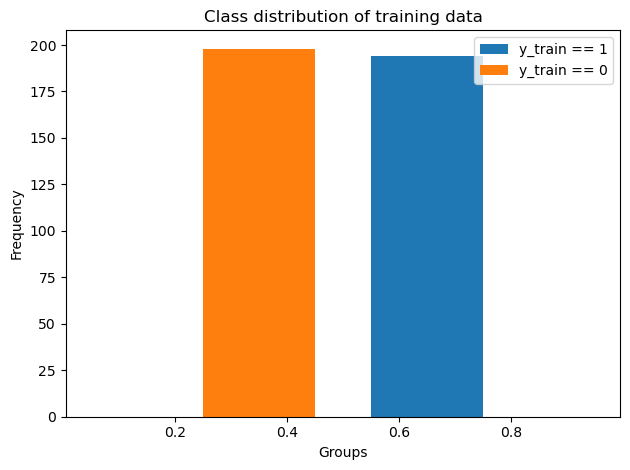

In [32]:
print(sum(y_train==1),sum(y_train==0))
plt.hist([y_train[y_train==1], y_train[y_train==0]], label=['y_train == 1', 'y_train == 0'], bins=2, rwidth=0.8)
plt.xlabel('Groups')
plt.ylabel('Frequency')
plt.title('Class distribution of training data')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# total train data including X and y
total_train_data = X_train.copy()
total_train_data['1-dead 0-alive'] = y_train['1-dead 0-alive']

**Histogram of each feature in X_train of clinical data**

We first plot histograms of each feature in X_train. Here we find that, except sex, almost every categorical variable has an imbalanced distribution.

For example, most patients are diagnosed as having Glioblastoma; most patients' 1p/19q genes are intact; most patients' IDH genes are wildtype. So, this model may finally be trained to perform well in predicting the survival for specific types of patients (because of the class imbalances) and perform badly on rare patient types. 

For continuous variables, MGMT index has a left-skewed distribution and age is approximately normally distributed.

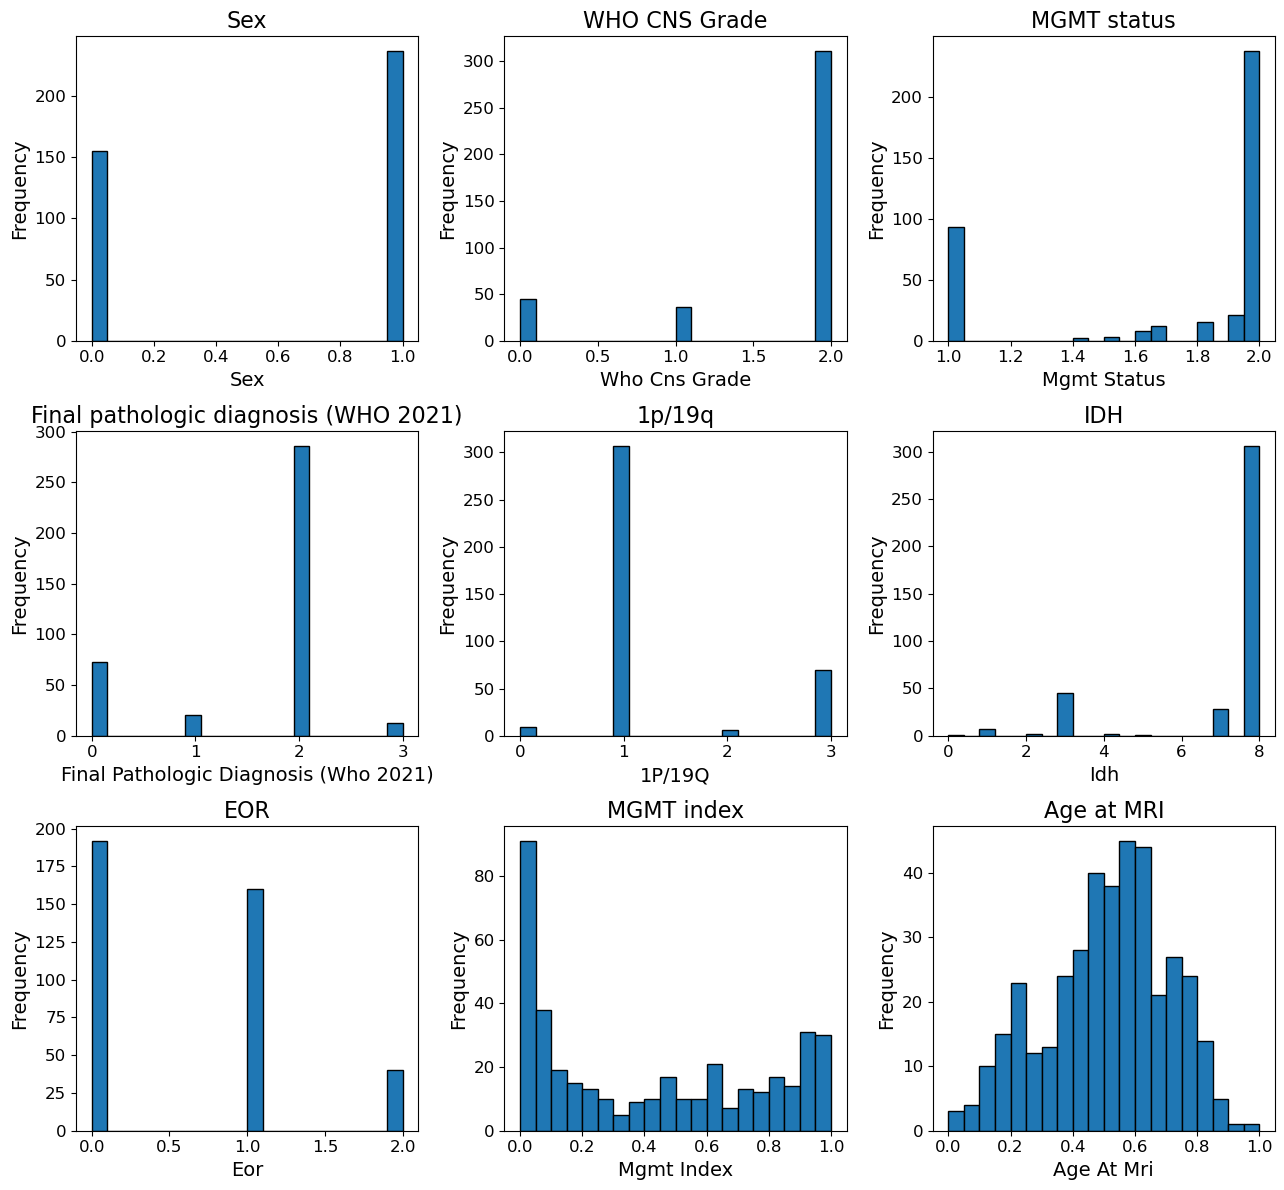

In [17]:
# histogram of each feature in X_train
fig, axs = plt.subplots(3, 3, figsize=(13, 12))
axs = axs.ravel()

# Loop through columns and create histograms
for col, ax in zip(X_train.columns, axs):
    ax.hist(X_train[col], bins=20, color="#1f77b4", edgecolor="black")
    col = col.replace("_", " ")
    ax.set_title(f"{col}", fontsize=16)  # Set title for each subplot
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=14)  # Set x-axis label
    ax.set_ylabel("Frequency", fontsize=14)  # Set y-axis label
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label font size
    ax.yaxis.get_offset_text().set_fontsize(12)  # Adjust y-axis offset font size
    ax.get_yaxis().get_major_formatter().set_useOffset(False)  # Disable y-axis offset

plt.tight_layout()

plt.show()

**Relationship between predictors and outcome**

We then evaluated the relationship between predictors and outcome. We found some insights regarding the relationship.

Almost all dead patients have `WHO CNS Grade` = 2 (which corresponds to the grade = 4 in the original data). WHO grade IV tumors were highly malignant, leading to death in relatively short periods of time in the absence of effective therapy (https://doi.org/10.1093/neuonc/noab106). They are also most likely to be diagnosed as having Glioblastoma, and most likely to have wildtype IDH genotype. The MGMT indexes in patients that are alive are generally higher than those in patients that are dead. The ages at MRI in patients that are alive are generally lower than those in patients that are dead.

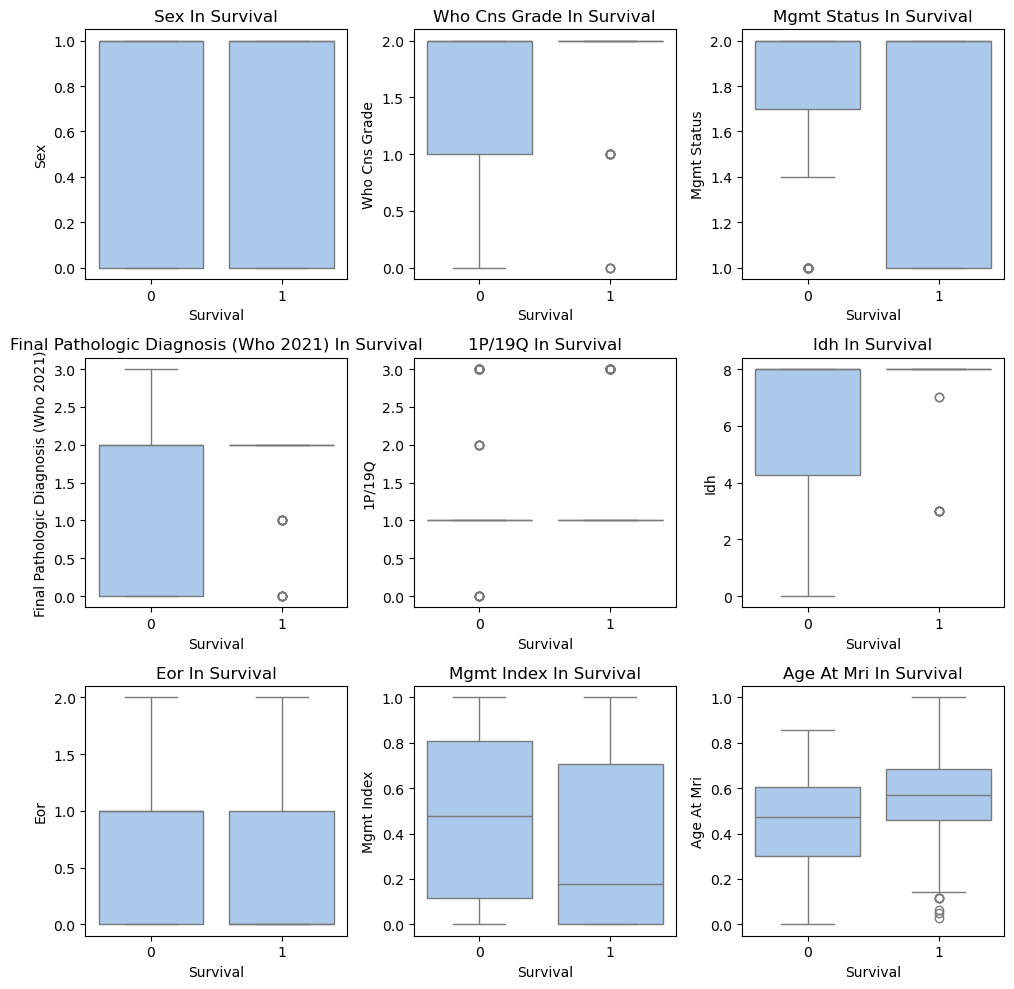

In [18]:
# relationship between predictors and outcome
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

# Loop through columns and create boxplots
for col, ax in zip(X_train.columns, axs):
    sns.boxplot(x=y_train['1-dead 0-alive'], y=X_train[col], color="#a1c9f4", ax=ax)
    #col = col.replace("_", " ")
    ax.set_title(f"{col} in survival".title() )  # Set title for each subplot
    ax.set_xlabel("Survival",fontsize=10)
    ax.set_ylabel(col.title(),fontsize=10)


plt.tight_layout()


Here we found in patients that are alive, younger patients tend to have a MGMT index of 0.4 to 0.6, and older patients tend to have a MGMT index of closer to 0 or 1. However, in the dead patients, the ages are generally older, and the MGMT index is more uniformly distributed across ages.

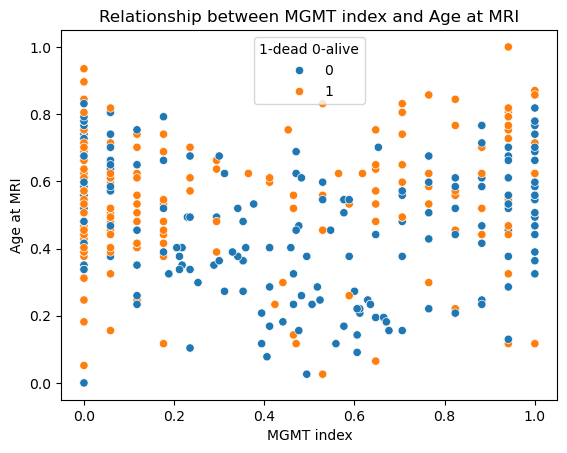

In [21]:
sns.scatterplot(data=total_train_data,x='MGMT index',y='Age at MRI',hue='1-dead 0-alive')
plt.title('Relationship between MGMT index and Age at MRI')
plt.show()

**Correlation Heatmap of predictors**

Since scatterplot may not be suitable for showing the relationships of different predictors, we also examined the correlation heatmap of the predictors. We found that final diagnosis is correlated with IDH; age at MRI is correlated with CNS grade, final diagnosis and IDH. The collinearity shows the complex relationship between predictors.

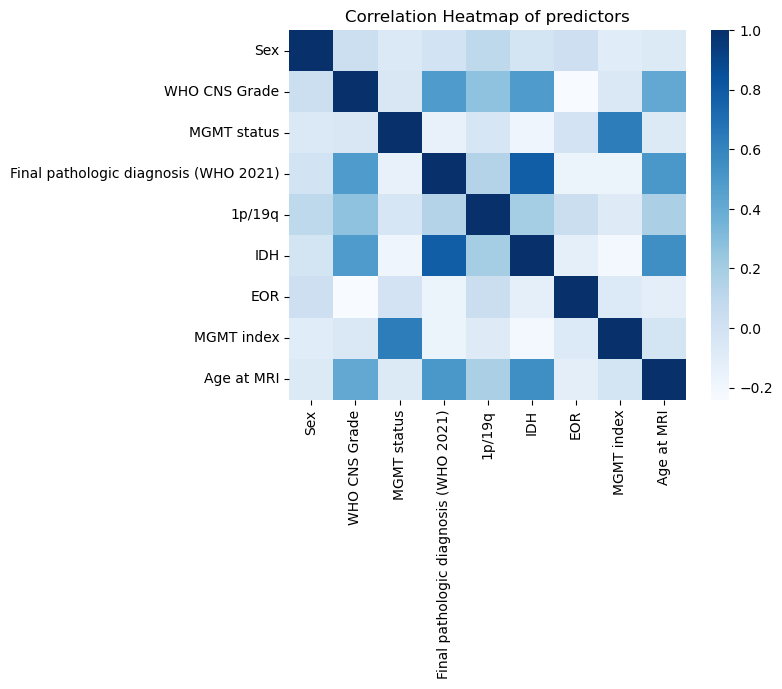

In [23]:
cormat = X_train.corr()
round(cormat,2)
sns.heatmap(cormat,cmap="Blues")
plt.title("Correlation Heatmap of predictors")
plt.show()

**PCA of One-Hot encoded data**

The PCA results of the One-Hot encoded data are shown below. The first component explains 21.55% of the variance, and the second component explains 11.34% of the variance. The PCA results show that there are clusters where observations of dead patients dominate, and patients that are alive are distributed wide around. This result shows that we can learn from the clinical data to predict the outcome.

array([0.21548757, 0.11335458])

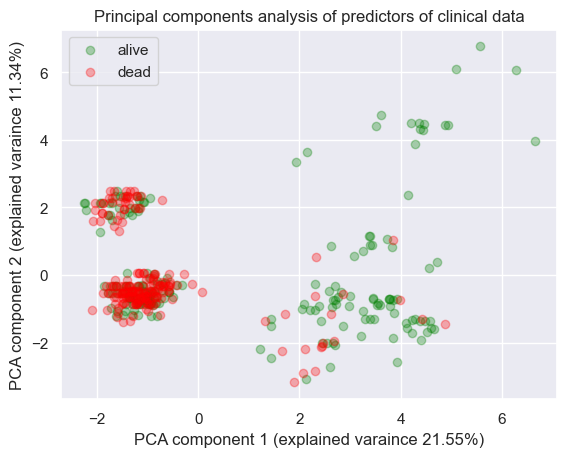

In [53]:
from sklearn.decomposition import PCA
##PCA
X_std = StandardScaler().fit_transform(X_train_ohe)
pca = PCA(n_components=2).fit(X_std)
X_pca = pca.transform(X_std)
display(pca.explained_variance_ratio_)

#plot
sns.set(font_scale=1)
alive = y_train['1-dead 0-alive'] == 0
dead = y_train['1-dead 0-alive'] == 1

plt.scatter(X_pca[alive,0], X_pca[alive,1], c='green', alpha=0.3, label="alive")
plt.scatter(X_pca[dead,0], X_pca[dead,1], c='red', alpha=0.3, label="dead")

plt.title("Principal components analysis of predictors of clinical data")
plt.xlabel(f"PCA component 1 (explained varaince {pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PCA component 2 (explained varaince {pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend();

#### Key findings from the EDA of the clinical data

- There are only class imbalance issues on predictors, not the outcome. The imbalance may cause instability of the model performance for rare types of patients.

- Some predictors, for instance, WHO CNS Grade, IDH and final diagnosis, are highly predictve for the death of a patient. The variance within the predictors is also related to the outcome, showing the predictive power of the predictors.

- Some predictors are correlated, showing complex relationships between predictors.

### MRI image data <div id='image_eda'></div>

**Image data EDA and Downsampling**

Next, we start to address the MRI images. In the previous part, we have selected and investigated images from the following 5 MRI techniques which have been commonly used in brain imaging : T1-weighted (T1), T1-weighted postcontrast (T1c), T2-weighted (T2), fluid-attenuated inversion recovery (FLAIR), arterial spin labeling perfusion (ASL). This is a decision made because of the GPU constraint. However, after further investigation, we found that in this dataset, there are existing tumor-segemented MRI images, which we think would be quite impoartant. Because only tumor-relevant information is retained in the segmented images, compared with other MRI images, they are less noisy. Given the 3D nature of the MRI image, this would greatly enhance our model performance and reduce computation costs. 

In [8]:
# find patient that has tumor segementation
patient_id_with_tumor_seq=[]

# Examine the meta data for images
df = pd.read_csv("PKG - UCSF-PDGM-v3-20230111/UCSF-PDGM-v3.sums", header=None,sep=' ') # a list of image file names
df.rename(columns={0: 'col1', 1: 'file_name'}, inplace=True)
df = df.drop(columns=['col1'])

for ind,row in df.iterrows():
    if "tumor_segmentation" in row[0]:
        a=row[0].split("_tumor_segmentation")
        pid=a[0][-4:]
        if re.match(r'^\d{4}$', pid):
            patient_id_with_tumor_seq.append(pid)

# define our train and test dataset
train_withid=[ind for ind in X_train.index if ind in patient_id_with_tumor_seq]
test_withid= [ind for ind in X_test.index if ind in patient_id_with_tumor_seq]
print(f"There are {len(train_withid)} training data and {len(test_withid)} test data.")

There are 392 training data and 97 test data.


The dimension of the MRI tumor segmentation is (240, 240, 155)
The unique intensity of the voxels in MRI tumor segmentation is [0. 1. 2. 4.]


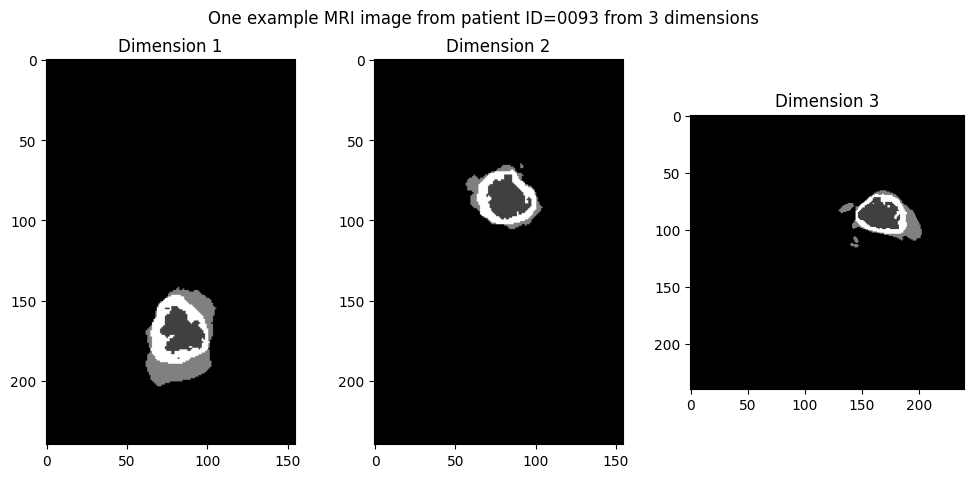

In [8]:
# define a function to read in MRI data
def read_image(patient_id, image_type):

  file_name = f"PKG - UCSF-PDGM-v3-20230111/UCSF-PDGM-v3/UCSF-PDGM-{patient_id}_nifti/UCSF-PDGM-{patient_id}_{image_type}.nii.gz"
  img_load = nib.load(file_name).get_fdata()

  return img_load

# the dimension of one 3D MRI tumor segmentation image
test_load = read_image(train_withid[0], "tumor_segmentation")
print(f"The dimension of the MRI tumor segmentation is {test_load.shape}")
print(f"The unique intensity of the voxels in MRI tumor segmentation is {np.unique(test_load)}")
# check the tumor position
position=np.where(test_load>0)
d1=np.unique(position[0])
d2=np.unique(position[1])
d3=np.unique(position[2])
d1_mid=int((min(d1)+max(d1))/2)
d2_mid=int((min(d2)+max(d2))/2)
d3_mid=int((min(d3)+max(d3))/2)

# plot one example
fig,axs=plt.subplots(1,3,figsize=(12,5))

axs[0].imshow(test_load[d1_mid,:,:],cmap="gray")
axs[0].set_title("Dimension 1")

axs[1].imshow(test_load[:,d2_mid,:],cmap="gray")
axs[1].set_title("Dimension 2")

axs[2].imshow(test_load[:,:,d3_mid],cmap="gray")
axs[2].set_title("Dimension 3")

plt.suptitle(f"One example MRI image from patient ID={train_withid[0]} from 3 dimensions");

The challenge we are now facing is the high-dimensionality of the image data, where each image has 240 * 240 * 155=8928000 voxels. One idea is to use only the tumor segments (where voxels' intensity > 0 ) as input. So, in the following part, we will explore the properties of the image as well as the properties of the segemented tumors in the image for the train dataset.

In [52]:
# group read in and process
# first we want to decide the tumor size distribution
number_of_patients=len(train_withid)
tumor_df = pd.DataFrame({
  "patient_id":train_withid,
  "d1_min": np.zeros(number_of_patients),
  "d1_max": np.zeros(number_of_patients),
  "d2_min": np.zeros(number_of_patients),
  "d2_max": np.zeros(number_of_patients),
  "d3_min": np.zeros(number_of_patients),
  "d3_max": np.zeros(number_of_patients),
  "d1_mid": np.zeros(number_of_patients),
  "d2_mid": np.zeros(number_of_patients),
  "d3_mid": np.zeros(number_of_patients),
  "volume": np.zeros(number_of_patients),
})
tumor_df.set_index("patient_id", inplace = True)

for ind in train_withid:
    temp = read_image(ind, "tumor_segmentation")
    position=np.where(temp>0)
    d1=np.unique(position[0])
    d2=np.unique(position[1])
    d3=np.unique(position[2])
    tumor_df.loc[ind,"d1_min"],tumor_df.loc[ind,"d1_max"]=min(d1),max(d1)
    tumor_df.loc[ind,"d2_min"],tumor_df.loc[ind,"d2_max"]=min(d2),max(d2)
    tumor_df.loc[ind,"d3_min"],tumor_df.loc[ind,"d3_max"]=min(d3),max(d3)
    tumor_df.loc[ind,"d1_mid"]=(min(d1)+max(d1))/2
    tumor_df.loc[ind,"d2_mid"]=(min(d2)+max(d2))/2
    tumor_df.loc[ind,"d3_mid"]=(min(d3)+max(d3))/2
    tumor_df.loc[ind,"volume"]=(max(d1)-min(d1))*(max(d2)-min(d2))*(max(d3)-min(d3))


The minimal tumor volume is 4284.0, while the maximal volume is 1486800.0


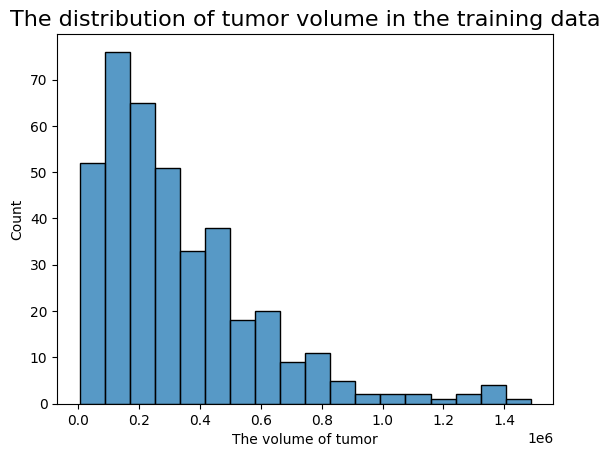

In [72]:
sns.histplot(data=tumor_df,x="volume")
plt.title("The distribution of tumor volume in the training data",fontsize=16);
plt.xlabel("The volume of tumor")
print(f"The minimal tumor volume is {min(tumor_df.volume)}, while the maximal volume is {max(tumor_df.volume)}")

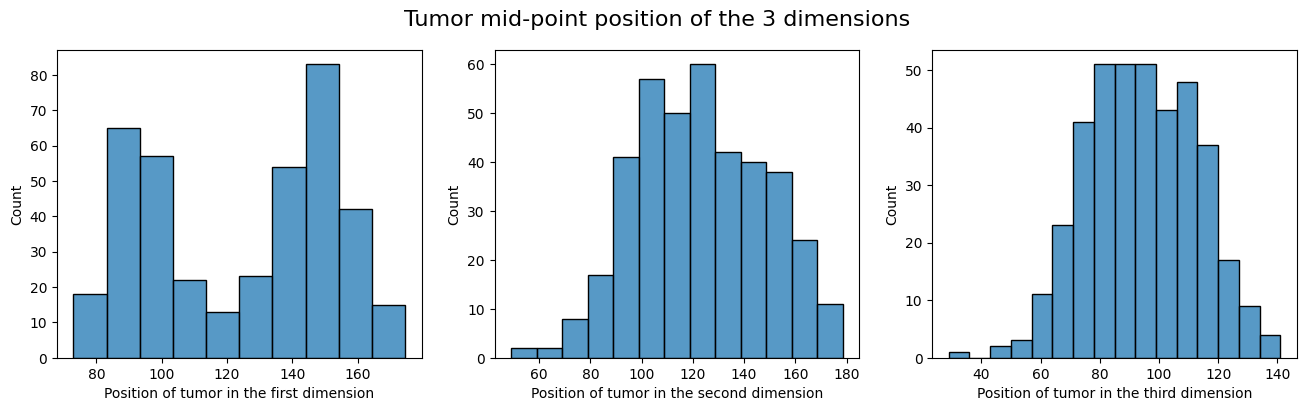

In [75]:
figs,axs=plt.subplots(1,3,figsize=(16,4))
sns.histplot(data=tumor_df,x="d1_mid",ax=axs[0])
axs[0].set_xlabel("Position of tumor in the first dimension")
sns.histplot(data=tumor_df,x="d2_mid",ax=axs[1])
axs[1].set_xlabel("Position of tumor in the second dimension")
sns.histplot(data=tumor_df,x="d3_mid",ax=axs[2])
axs[2].set_xlabel("Position of tumor in the third dimension")
plt.suptitle("Tumor mid-point position of the 3 dimensions",fontsize=16);

From the tumor volume and tumor postion histogram above, we can see that it is quite difficult to curve out the tumor in a fixed cubic (fixed in order to serve as model's input) while reducing the input's voxels. Therefore, we come up with the idea of 3D maxpooling, which is a technique to downsample the input along its spatial dimensions (depth, height, and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. Here, before 3D max-pooling, we combine the tumor segementation MRI and T2-weighted MRI as input, where tumor-segmented MRI is used as a mask to carve out the tumor regions in T2-weighted MRI images.

In [7]:
# masking and carving out tumor regions in T2 MRI
T2_masked_train=[]

for ind in train_withid:
    mask = read_image(ind, "tumor_segmentation")
    T2 = read_image(ind, "T2")
    T2[np.where(mask==0)]=0
    T2_masked_train.append(T2)

The maximal intensity of the pixel intensity in patient ID=0093 is 2344


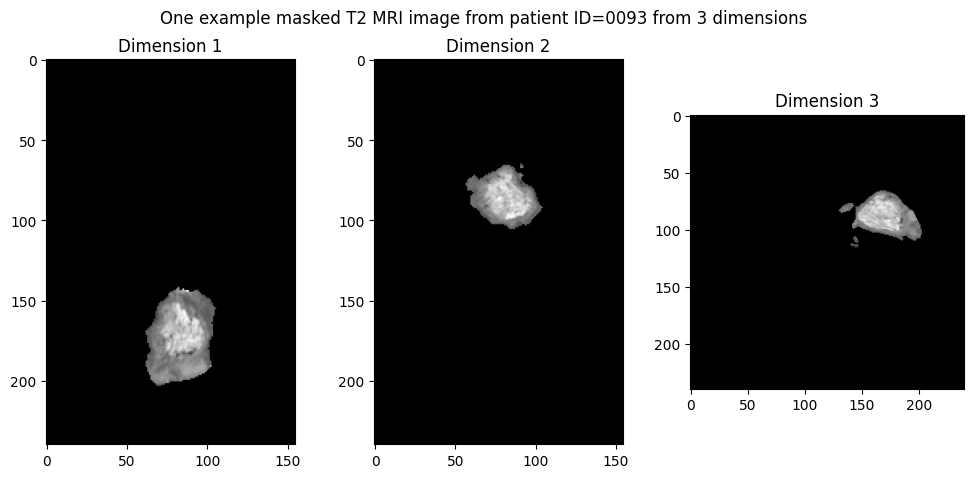

In [8]:
# visualize one masked T2 image 
# plot one example (ID=0093 in the train data)
masked_example=T2_masked_train[0]

fig,axs=plt.subplots(1,3,figsize=(12,5))


axs[0].imshow(masked_example[d1_mid,:,:],cmap="gray")
axs[0].set_title("Dimension 1")

axs[1].imshow(masked_example[:,d2_mid,:],cmap="gray")
axs[1].set_title("Dimension 2")

axs[2].imshow(masked_example[:,:,d3_mid],cmap="gray")
axs[2].set_title("Dimension 3")

plt.suptitle(f"One example masked T2 MRI image from patient ID={train_withid[0]} from 3 dimensions");

print(f"The maximal intensity of the voxel intensity in patient ID={train_withid[0]} is {np.max(masked_example):.0f}")

From the example of masked T2 plotted above, we could observe some difference in intensity between the positions of tumors. Also, since the range of voxel intensity is quite large, we will perform min-max scaling when training the model. Here, we first apply max3D pooling to downsample the data.

In [2]:
# build a downsample model
inputs=keras.Input((240,240,155,1))
outputs=keras.layers.MaxPool3D(pool_size=2)(inputs)

Downsample_model=keras.Model(inputs,outputs,name="Downsample_model")
Downsample_model.summary()

Model: "Downsample_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 155, 1)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 120, 120, 77, 1)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
tumors_downsampled=[]
for X in T2_masked_train:
    downsampled=Downsample_model.predict(np.expand_dims(X,axis=0))
    tumors_downsampled.append(downsampled[0])
tumors_downsampled=np.array(tumors_downsampled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

**Feature engineering and further exploration of the downsampled data**

In [ ]:
imgs_train = np.load("downsampled_data_trained.npz")
X_train_image = imgs_train['train']
X_train_image = X_train_image.reshape(-1,120,120,77,1)
X_test_image = np.load("downsampled_data_test.npz")
X_test_image = X_test_image['train']
X_test_image = X_test_image.reshape(-1,120,120,77,1)

For the downsampled data, we further performed feature engineering. We min-max scaled the voxels so that every voxel ranges from 0 to 1.

In [ ]:
# scaling the voxels according to the maximal values of voxel in that MRI
for (X,i) in zip(X_train_image,range(X_train_image.shape[0])):
    temp_max = np.max(X)
    # since minmal value is 0, minimax normalization
    X_train_image[i] = X/temp_max

for (X,i) in zip(X_test_image,range(X_test_image.shape[0])):
    temp_max = np.max(X)
    # since minmal value is 0, minimax normalization
    X_test_image[i] = X/temp_max

((392, 120, 120, 77, 1), (97, 120, 120, 77, 1))

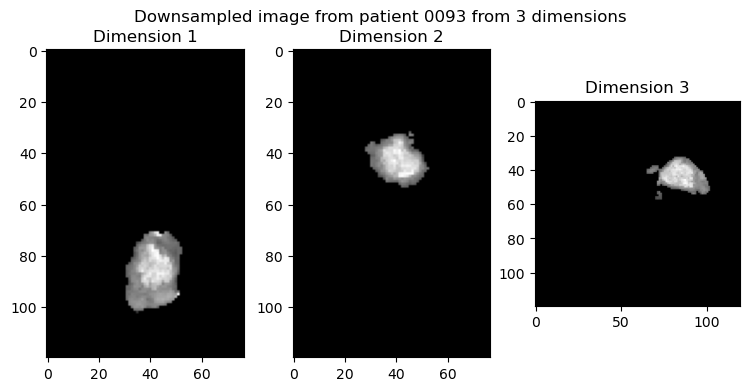

In [33]:
def plot_3d_MRI(img,title):
    # find where the voxel value is not 0
    pos=np.where(img>0)
    mid_1=int((max(pos[0])+min(pos[0]))/2)
    mid_2=int((max(pos[1])+min(pos[1]))/2)
    mid_3=int((max(pos[2])+min(pos[2]))/2)
    fig,axs=plt.subplots(1,3,figsize=(9,4))
    axs[0].imshow(img[mid_1,:,:],cmap="gray")
    axs[0].set_title("Dimension 1")
    axs[1].imshow(img[:,mid_2,:],cmap="gray")
    axs[1].set_title("Dimension 2")
    axs[2].imshow(img[:,:,mid_3],cmap="gray")
    axs[2].set_title("Dimension 3")
    plt.suptitle(title)
    
plot_3d_MRI(X_train_image[0,:,:,:,:],f"Downsampled image from patient {X_train.index[0]} from 3 dimensions")
X_train_image.shape,X_test_image.shape

In [15]:
np.savez_compressed("downsampled_data_trained",train=tumors_downsampled)

Before we upload the processed train data to the Jupyter hub to train our model using GPU, we checked locally whether the compression will cause changes.

In [16]:
data=np.load("downsampled_data_trained.npz")
np.array_equal(tumors_downsampled,data["train"])

True

#### Key findings from the EDA of the MRI data
- According to the EDA analysis of the tumor size, even the smallest tumor has around 4284 voxels, which suggested the plausibility of our down-sampling approach. 
- From the tumor volume and tumor position histogram, we can see that it is quite difficult to curve out the tumor in a fixed cubic (fixed in order to serve as model's input) while reducing the input's voxels. Therefore, we come up with the idea of 3D maxpooling, which is a technique to downsample the input along its spatial dimensions (depth, height, and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. Here, before 3D max-pooling, we combine the tumor segementation MRI and T2-weighted MRI as input, where tumor-segmented MRI is used as a mask to carve out the tumor regions in T2-weighted MRI images.
- From the visualization of 3D MRI data, we could observe some difference in intensity between the positions of tumors. Also, since the range of voxel intensity is quite large, we will perform min-max scaling when training the model.

To implement a 2D CNN model, we performed maxpooling in the 3rd dimension of the original data (Dim: (120, 120, 77, 1) to (120, 120, 1)).

In [15]:
# dim: (120, 120, 77, 1)
# maxpooling in the 3rd dimension

def max_pool_3rd_dim(original_image, input_size, width=120, height=120):
    X_2d_maxpool = np.ndarray((input_size,width,height,1))
    for one_img in range(input_size):
        for i in range(width):
            for j in range(height):
                max_in_i_j = max(original_image[one_img,i,j,:,0])
                X_2d_maxpool[one_img,i,j,0] = max_in_i_j
    return X_2d_maxpool
X_train_2d_maxpool = max_pool_3rd_dim(X_train_image, 392)
X_test_2d_maxpool = max_pool_3rd_dim(X_test_image, 97)

In [16]:
X_full = np.vstack((X_train_2d_maxpool, X_test_2d_maxpool))
X_full.shape

(489, 120, 120, 1)

In [17]:
original_x_reshaped=X_full.reshape(489,-1)
original_x_reshaped.shape

(489, 14400)

#### Dimension reduction of reshape 2D images

In [11]:
## PCA plot
from sklearn.decomposition import PCA
def pca_plot(train_data,title):
    ##PCA
    X_std = StandardScaler().fit_transform(train_data[:392,:])
    pca = PCA(n_components=2).fit(X_std)
    X_pca = pca.transform(X_std)
    display(pca.explained_variance_ratio_)
    
    #plot
    sns.set(font_scale=1)
    alive = y_train['1-dead 0-alive'] == 0
    dead = y_train['1-dead 0-alive'] == 1
    
    plt.scatter(X_pca[alive,0], X_pca[alive,1], c='green', alpha=0.3, label="alive")
    plt.scatter(X_pca[dead,0], X_pca[dead,1], c='red', alpha=0.3, label="dead")
    
    plt.title(title)
    plt.xlabel(f"PCA component 1 (explained varaince {pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PCA component 2 (explained varaince {pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.legend();

array([0.16971369, 0.11936625])

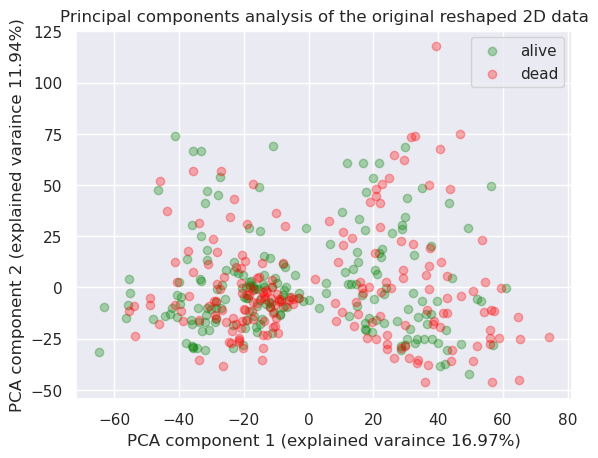

In [126]:
pca_plot(original_x_reshaped, "Principal components analysis of the original reshaped 2D data")

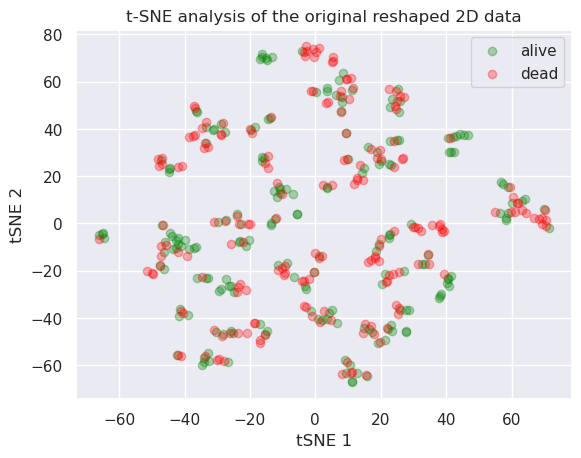

In [128]:
from sklearn.manifold import TSNE
def tsne_plot(train_data,title):
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(train_data[:392,:])
    
    sns.set(font_scale=1)
    alive = y_train['1-dead 0-alive'] == 0
    dead = y_train['1-dead 0-alive'] == 1
    
    plt.scatter(X_embedded[alive,0], X_embedded[alive,1], c='green', alpha=0.3, label="alive")
    plt.scatter(X_embedded[dead,0], X_embedded[dead,1], c='red', alpha=0.3, label="dead")
    
    plt.title(title)
    plt.xlabel(f"tSNE 1")
    plt.ylabel(f"tSNE 2")
    plt.legend();

tsne_plot(original_x_reshaped,'t-SNE analysis of the original reshaped 2D data')

From the PCA plot, we do not observe obvious distinction between the survival outcomes. This observation is reasonable, given that only 2 dimensions are considered in the plot. For example, in the PCA plot, the first two dimensions only explained 17% and 12% of the total variation in the data. Besides, the relationship between MRI image and survival outcome could be very complicated. Rough dimension reduction methods could not recapitulate the complicated relationship, thus motivating us to use neural network models to perform the classification task.

[back](#content)

## Part 4. Baseline models and result assessment <div id='part4'>


#### 2D CNN baseline model <div id='2dcnn'></div>

Convolutional Neural Networks (CNNs) were originally developed for analyzing visual imagery and have become highly sophisticated for processing 2D images. Given this strong foundation, we have chosen to design a 2D CNN model as our initial baseline. Below is an example of a 2D image that we've downsampled for this purpose and the model built from scratch. 

(392, 120, 120, 1)

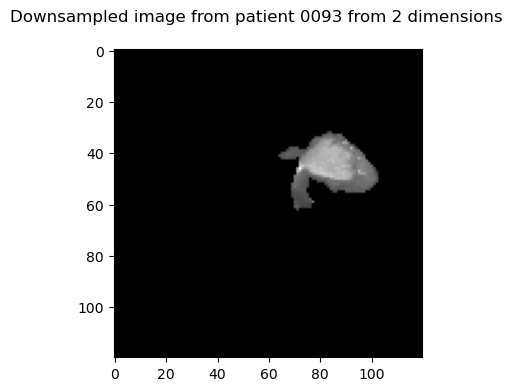

In [18]:
def plot_2d_MRI(img,title):
    fig,axs=plt.subplots(1,1,figsize=(9,4))
    axs.imshow(img[:,:],cmap="gray")
    plt.suptitle(title)
    
plot_2d_MRI(X_train_2d_maxpool[0,:,:,:],f"Downsampled image from patient {X_train.index[0]} from 2 dimensions")
X_train_2d_maxpool.shape

Then we built the 2D CNN baseline model.

This model is just a CNN model with 4 convolutional layers and 4 fully connected layers. The number of layers are quite small because of the limited computational resources. We added batch normalization, dropout and L1, L2 regularization to improve the model performance. This model can be used as a reference model with a moderate performance.

In [38]:
#model
def get_model(width=120, height=120):
    """Build a 2D convolutional neural network model."""

    inputs = keras.Input((width, height, 1))
    regularizer = tf.keras.regularizers.L1L2(l1=0.002,l2=0.002)

    x = Conv2D(128,(4,4),padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2),strides=2, padding="same")(x)
    x = Conv2D(96,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(96,(2,2),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2),strides=2, padding="same")(x)
    x = Conv2D(64,(2,2),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4,4),strides=4, padding="same")(x)
    x = Flatten()(x)
    #x = layers.GlobalMaxPooling2D()(x)
    x = Dense(64, activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
    x = Dropout(rate=0.35,seed=109)(x)
    x = Dense(32, activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
    x = Dropout(rate=0.35,seed=109)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
    x = Dropout(rate=0.35,seed=109)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
    x = Dropout(rate=0.35,seed=109)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model


# Build model.
model = get_model()
model.summary()

Model: "2dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 120, 120, 128)     2176      
                                                                 
 batch_normalization_28 (Ba  (None, 120, 120, 128)     512       
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 120, 120, 128)     0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 60, 60, 96)        110688

In [39]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.keras", save_best_only=True, monitor='val_acc'
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

# Train the model, doing validation at the end of each epoch
epochs = 150
model.fit(
    X_train_2d_maxpool,
    y_train,
    validation_split=0.20,
    batch_size=10,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/150
32/32 - 5s - loss: 11.2532 - acc: 0.4984 - val_loss: 10.2239 - val_acc: 0.4304 - 5s/epoch - 164ms/step
Epoch 2/150
32/32 - 3s - loss: 9.6120 - acc: 0.5144 - val_loss: 8.7996 - val_acc: 0.5316 - 3s/epoch - 85ms/step
Epoch 3/150
32/32 - 3s - loss: 8.2254 - acc: 0.5335 - val_loss: 7.5746 - val_acc: 0.5190 - 3s/epoch - 78ms/step
Epoch 4/150
32/32 - 3s - loss: 7.0830 - acc: 0.5176 - val_loss: 6.5588 - val_acc: 0.4937 - 3s/epoch - 79ms/step
Epoch 5/150
32/32 - 3s - loss: 6.2198 - acc: 0.4633 - val_loss: 5.7437 - val_acc: 0.4810 - 3s/epoch - 78ms/step
Epoch 6/150
32/32 - 3s - loss: 5.4279 - acc: 0.5559 - val_loss: 5.1128 - val_acc: 0.4810 - 3s/epoch - 78ms/step
Epoch 7/150
32/32 - 3s - loss: 4.8904 - acc: 0.4888 - val_loss: 4.6398 - val_acc: 0.4937 - 3s/epoch - 79ms/step
Epoch 8/150
32/32 - 3s - loss: 4.4513 - acc: 0.5272 - val_loss: 4.2566 - val_acc: 0.4810 - 3s/epoch - 79ms/step
Epoch 9/150
32/32 - 3s - loss: 4.1091 - acc: 0.5048 - val_loss: 3.9372 - val_acc: 0.4810 - 3s/epoch -

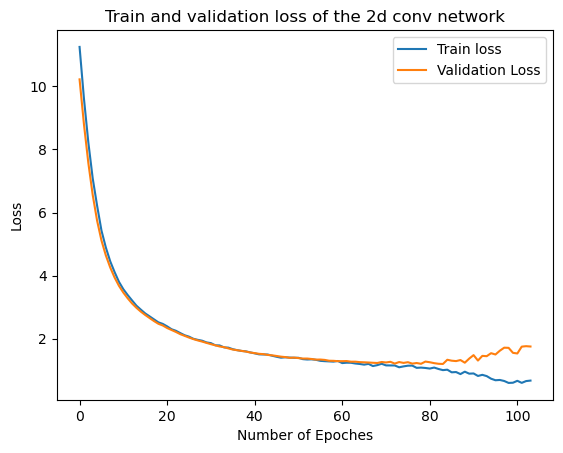

In [40]:
plt.plot(model.history.history["loss"],label="Train loss")
plt.plot(model.history.history["val_loss"],label="Validation Loss")
plt.title("Train and validation loss of the 2d conv network")
plt.xlabel("Number of Epoches")
plt.ylabel("Loss")
plt.legend();

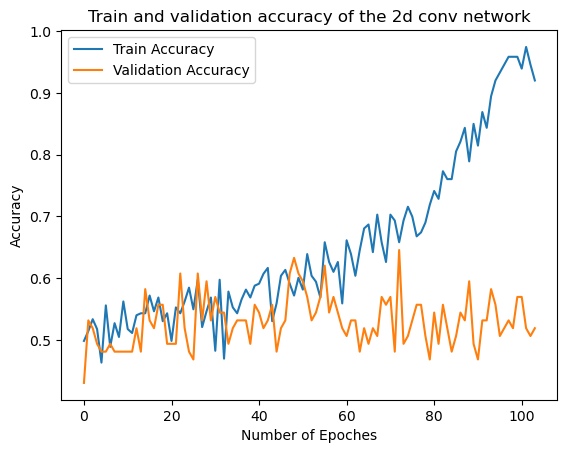

In [41]:
plt.plot(model.history.history["acc"],label="Train Accuracy")
plt.plot(model.history.history["val_acc"],label="Validation Accuracy")
plt.title("Train and validation accuracy of the 2d conv network")
plt.xlabel("Number of Epoches")
plt.ylabel("Accuracy")
plt.legend();


In [ ]:
# save model and train and val accuracies and losses
# numbers: best_val_acc(~0.6 to 0.7)
path = 'model_2dcnn_val_acc_6456'
os.chdir('/home/u_478891/project')
if not os.path.exists(path):
    os.mkdir(path)
os.chdir(path)
train_acc = model.history.history["acc"]
np.save('train_acc.npy', train_acc)
val_acc = model.history.history["val_acc"]
np.save('val_acc.npy', val_acc)
train_loss = model.history.history["loss"]
np.save('train_loss.npy', train_loss)
val_loss = model.history.history["val_loss"]
np.save('val_loss.npy', val_loss)
model.save(f'{path}.h5')

In [43]:
test_acc = model.evaluate(X_test_2d_maxpool, y_test)[1]
test_acc

4/4 [==============================] - 0s 41ms/step - loss: 1.7617 - acc: 0.5258


0.5257731676101685

Here, the validation accuracy is 0.6456 and the test accuracy is 0.5258. The baseline model does learn something but does not perform very well on the prediction task.

We will try some advanced modeling techniques in order to improve our prediction accuracy.

## Transfer Learning <div id='transfer'></div>

To enhance prediction accuracy, we leverage pre-trained models that have been trained on extensive image datasets and adapt these models to our specific tasks and inputs. For this purpose, we employed the ResNet50 model through transfer learning. We chose ResNet50 due to its residual connection architecture, which addresses the vanishing gradient issue and facilitates the development of deeper networks. This attribute makes ResNet50 exceptionally effective for image processing tasks.

In [18]:
## Preprocessing
### Add in channels to make the 2D downsampled MRI image compactible with the ResNet trained on Imagenet
###input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with "channels_last" data format) or (3, 224, 224) (with "channels_first" data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
x_train_transfer=tf.repeat(X_train_2d_maxpool,3,axis=3)
x_test_transfer=tf.repeat(X_test_2d_maxpool,3,axis=3)

x_train_transfer.shape,x_test_transfer.shape

(TensorShape([392, 120, 120, 3]), TensorShape([97, 120, 120, 3]))

In [70]:
# build the model

base_model= tf.keras.applications.ResNet50(weights="imagenet",include_top=False,input_shape=(120,120,3))

for layer in base_model.layers:
    layer.trainable=False

## add the top
regularizer = tf.keras.regularizers.L1L2(l1=0.001,l2=0.001)

x=layers.GlobalAveragePooling2D()(base_model.output)
x=layers.Flatten()(x)
x=layers.Dense(128,activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(64,activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
x=layers.Dropout(0.2)(x)

predictions=layers.Dense(1,activation="sigmoid")(x)

In [64]:
head_model=Model(inputs=base_model.input,outputs=predictions)
print(head_model.summary())
head_model.compile(loss="binary_crossentropy",
                   metrics=["accuracy"],
                   optimizer=keras.optimizers.Adam(learning_rate=0.002))

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.keras", save_best_only=True,monitor='val_loss',save_weights_only=False
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)


# Train the model, doing validation at the end of each epoch
epochs = 10
head_model.fit(
    x_train_transfer,
    y_train,
    validation_split=0.20,
    batch_size=4,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/10
79/79 - 9s - loss: 2.3302 - accuracy: 0.5016 - val_loss: 1.0663 - val_accuracy: 0.5190 - 9s/epoch - 110ms/step
Epoch 2/10
79/79 - 2s - loss: 0.9872 - accuracy: 0.4760 - val_loss: 0.9213 - val_accuracy: 0.4810 - 2s/epoch - 29ms/step
Epoch 3/10
79/79 - 2s - loss: 0.8961 - accuracy: 0.4984 - val_loss: 0.8624 - val_accuracy: 0.5190 - 2s/epoch - 29ms/step
Epoch 4/10
79/79 - 2s - loss: 0.8471 - accuracy: 0.5080 - val_loss: 0.8324 - val_accuracy: 0.5190 - 2s/epoch - 28ms/step
Epoch 5/10
79/79 - 2s - loss: 0.8292 - accuracy: 0.4824 - val_loss: 0.8125 - val_accuracy: 0.5190 - 2s/epoch - 28ms/step
Epoch 6/10
79/79 - 2s - loss: 0.8084 - accuracy: 0.4473 - val_loss: 0.8001 - val_accuracy: 0.5190 - 2s/epoch - 28ms/step
Epoch 7/10
79/79 - 2s - loss: 0.7955 - accuracy: 0.5048 - val_loss: 0.7917 - val_accuracy: 0.5190 - 2s/epoch - 28ms/step
Epoch 8/10
79/79 - 2s - loss: 0.7967 - accuracy: 0.4601 - val_loss: 0.7890 - val_accuracy: 0.5190 - 2s/epoch - 28ms/step
Epoch 9/10
79/79 - 2s - loss: 0

In [38]:
head_model = keras.models.load_model('2d_image_classification.keras')
head_model.trainable = True

learning_rate = 1e-5

# learning rate scheduler
def scheduler(epoch, lr):
    warmup_epochs = 10
    decay_epochs = number_of_epochs - warmup_epochs
    if epoch < warmup_epochs:
        return lr
    else:
        return lr * (1 - 1/2*(epoch - warmup_epochs) / decay_epochs)
        
# Learning rate scheduler callback
lr_callback = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# Number of epochs for training
number_of_epochs = 100

checkpoint_tf = keras.callbacks.ModelCheckpoint(
    "2d_image_classification_tf", save_best_only=True,monitor='val_binary_accuracy',save_weights_only=False
)
early_stopping_tf = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=25)


head_model.compile(optimizer=keras.optimizers.Adam(learning_rate,epsilon=1e-08),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

head_model.fit(x_train_transfer,y_train,validation_split=0.20,batch_size=4, epochs=number_of_epochs, callbacks=[checkpoint_tf, early_stopping_tf,lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/100
78/79 [============================>.] - ETA: 0s - loss: 0.7265 - binary_accuracy: 0.4936INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


79/79 [==============================] - 75s 542ms/step - loss: 0.7264 - binary_accuracy: 0.4952 - val_loss: 0.7102 - val_binary_accuracy: 0.4810 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/100
79/79 [==============================] - 3s 40ms/step - loss: 0.7091 - binary_accuracy: 0.4728 - val_loss: 0.7083 - val_binary_accuracy: 0.4810 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 3/100
79/79 [==============================] - 3s 39ms/step - loss: 0.7081 - binary_accuracy: 0.4696 - val_loss: 0.7078 - val_binary_accuracy: 0.4810 - lr: 1.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 4/100
79/79 [==============================] - 3s 39ms/step - loss: 0.7072 - binary_accuracy: 0.5048 - val_loss: 0.7075 - val_binary_accuracy: 0.4810 - lr: 1.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-06

INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


79/79 [==============================] - 42s 534ms/step - loss: 0.6889 - binary_accuracy: 0.6773 - val_loss: 0.7146 - val_binary_accuracy: 0.5063 - lr: 1.0000e-05

Epoch 10: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 10/100
79/79 [==============================] - 3s 40ms/step - loss: 0.6645 - binary_accuracy: 0.6869 - val_loss: 0.7178 - val_binary_accuracy: 0.4937 - lr: 1.0000e-05

Epoch 11: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 11/100
79/79 [==============================] - 3s 39ms/step - loss: 0.6497 - binary_accuracy: 0.7029 - val_loss: 0.7226 - val_binary_accuracy: 0.4557 - lr: 1.0000e-05

Epoch 12: LearningRateScheduler setting learning rate to 9.944444193226648e-06.
Epoch 12/100
79/79 [==============================] - ETA: 0s - loss: 0.6140 - binary_accuracy: 0.7061INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


79/79 [==============================] - 39s 498ms/step - loss: 0.6140 - binary_accuracy: 0.7061 - val_loss: 0.7271 - val_binary_accuracy: 0.5316 - lr: 9.9444e-06

Epoch 13: LearningRateScheduler setting learning rate to 9.833950348871035e-06.
Epoch 13/100
79/79 [==============================] - 3s 40ms/step - loss: 0.6003 - binary_accuracy: 0.7732 - val_loss: 0.7283 - val_binary_accuracy: 0.5063 - lr: 9.8340e-06

Epoch 14: LearningRateScheduler setting learning rate to 9.67005139500543e-06.
Epoch 14/100
79/79 [==============================] - 3s 39ms/step - loss: 0.5844 - binary_accuracy: 0.8083 - val_loss: 0.7303 - val_binary_accuracy: 0.5316 - lr: 9.6701e-06

Epoch 15: LearningRateScheduler setting learning rate to 9.455161408469495e-06.
Epoch 15/100
79/79 [==============================] - ETA: 0s - loss: 0.5861 - binary_accuracy: 0.8051INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


79/79 [==============================] - 41s 524ms/step - loss: 0.5861 - binary_accuracy: 0.8051 - val_loss: 0.7291 - val_binary_accuracy: 0.6076 - lr: 9.4552e-06

Epoch 16: LearningRateScheduler setting learning rate to 9.192518114610317e-06.
Epoch 16/100
79/79 [==============================] - 3s 40ms/step - loss: 0.5720 - binary_accuracy: 0.8371 - val_loss: 0.7278 - val_binary_accuracy: 0.6076 - lr: 9.1925e-06

Epoch 17: LearningRateScheduler setting learning rate to 8.886101234869177e-06.
Epoch 17/100
79/79 [==============================] - 3s 39ms/step - loss: 0.5407 - binary_accuracy: 0.8754 - val_loss: 0.7393 - val_binary_accuracy: 0.5949 - lr: 8.8861e-06

Epoch 18: LearningRateScheduler setting learning rate to 8.540530951803602e-06.
Epoch 18/100
79/79 [==============================] - 3s 39ms/step - loss: 0.5471 - binary_accuracy: 0.8850 - val_loss: 0.7421 - val_binary_accuracy: 0.5316 - lr: 8.5405e-06

Epoch 19: LearningRateScheduler setting learning rate to 8.160951721139

INFO:tensorflow:Assets written to: 2d_image_classification_tf/assets


79/79 [==============================] - 41s 528ms/step - loss: 0.4808 - binary_accuracy: 0.9137 - val_loss: 0.7873 - val_binary_accuracy: 0.6329 - lr: 6.8747e-06

Epoch 23: LearningRateScheduler setting learning rate to 6.416405691804054e-06.
Epoch 23/100
79/79 [==============================] - 3s 40ms/step - loss: 0.4652 - binary_accuracy: 0.9265 - val_loss: 0.7947 - val_binary_accuracy: 0.6076 - lr: 6.4164e-06

Epoch 24: LearningRateScheduler setting learning rate to 5.952998473427821e-06.
Epoch 24/100
79/79 [==============================] - 3s 39ms/step - loss: 0.4670 - binary_accuracy: 0.9329 - val_loss: 0.7685 - val_binary_accuracy: 0.6076 - lr: 5.9530e-06

Epoch 25: LearningRateScheduler setting learning rate to 5.489987446101926e-06.
Epoch 25/100
79/79 [==============================] - 3s 39ms/step - loss: 0.4355 - binary_accuracy: 0.9265 - val_loss: 0.8144 - val_binary_accuracy: 0.6076 - lr: 5.4900e-06

Epoch 26: LearningRateScheduler setting learning rate to 5.032488464469

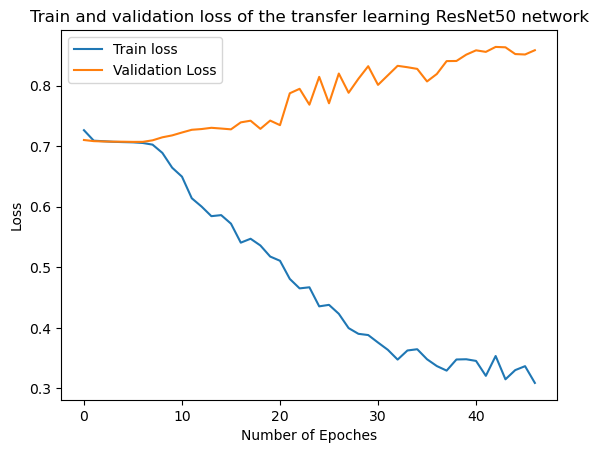

In [39]:
plt.plot(head_model.history.history["loss"],label="Train loss")
plt.plot(head_model.history.history["val_loss"],label="Validation Loss")
plt.title("Train and validation loss of the transfer learning ResNet50 network")
plt.xlabel("Number of Epoches")
plt.ylabel("Loss")
plt.legend();

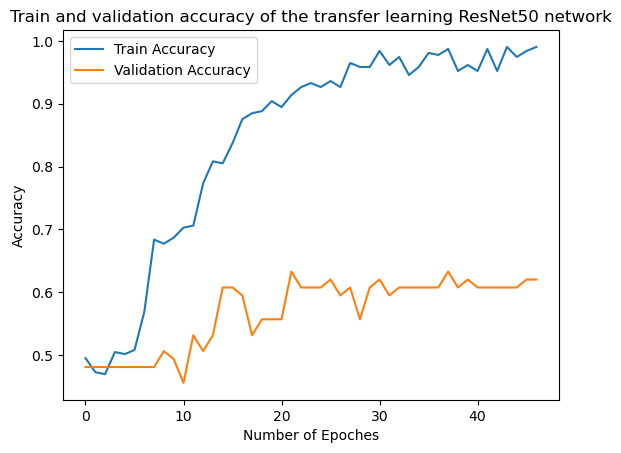

In [40]:
plt.plot(head_model.history.history["binary_accuracy"],label="Train Accuracy")
plt.plot(head_model.history.history["val_binary_accuracy"],label="Validation Accuracy")
plt.title("Train and validation accuracy of the transfer learning ResNet50 network")
plt.xlabel("Number of Epoches")
plt.ylabel("Accuracy")
plt.legend();

In [41]:
head_model.save('transfer')

INFO:tensorflow:Assets written to: transfer/assets


INFO:tensorflow:Assets written to: transfer/assets


In [42]:
test_acc_transfer = head_model.evaluate(x_test_transfer, y_test)[1]
test_acc_transfer

4/4 [==============================] - 0s 36ms/step - loss: 0.7798 - binary_accuracy: 0.6082


0.6082473993301392

For transfer learning of the ResNet50 model, the validation accuracy is 0.6329, and the test accuracy is 0.6082. This model performs much better than our simple 2D CNN model in less overfitting to the training and validation data and its stable performance between epochs.

## Classifier for clinical data <div id='classifier_clinic'></div>
### Dense layer, same as what has been used in 2D CNN model
Then we use dense layers as a classifier that only clinical data as inputs to predict the mortality status of patients. 

In [ ]:
clinic = layers.Input(shape=(X_train_ohe.shape[1],))
z = layers.Dense(32, activation='relu')(clinic)

regularizer = tf.keras.regularizers.L1L2(l1=0.001,l2=0.001)
a=layers.Dense(16,activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(z)
a=layers.Dense(8,activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(a)
classification=layers.Dense(1,activation="sigmoid")(a)

classifier = keras.models.Model(inputs=clinic, outputs=classification)

classifier.compile(loss="binary_crossentropy",
                   metrics=["accuracy"],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.002))
classifier.summary()
epochs = 100
classifier.fit(
    X_train_ohe, 
    y_train,
    validation_split=0.20,
    batch_size=16,
    epochs=epochs,
    verbose=0
)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 22)]              0         
                                                                 
 dense_62 (Dense)            (None, 32)                736       
                                                                 
 dense_63 (Dense)            (None, 16)                528       
                                                                 
 dense_64 (Dense)            (None, 8)                 136       
                                                                 
 dense_65 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1409 (5.50 KB)
Trainable params: 1409 (5.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
test_loss, test_acc_transfer = classifier.evaluate(X_test_ohe, y_test)
print("Test Accuracy:", test_acc_transfer)

4/4 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.6082
Test Accuracy: 0.6082473993301392


## Transfer learning of images with clinical data <div id='transfer_clinic'></div>


Following the prediction of mortality status using either images or clinical data, we integrate clinical data features with image data by introducing an additional pathway prior to the dense layers in our 2D CNN model. In this setup, we utilize both pre-trained layers from ResNet50 and layers we have trained ourselves to extract features from images. This approach allows for a more comprehensive analysis by combining different types of data.

In [153]:
base_model= keras.models.load_model("transfer")

for layer in base_model.layers:
    layer.trainable=False
    
# Image feature extraction pathway
y = base_model.layers[-6].output
base_model_subset = Model(inputs=base_model.input, outputs=y)
y1 = base_model_subset.output

# Clinical data pathway
clinic_input = layers.Input(shape=(X_train_ohe.shape[1],))
y2 = layers.Dense(32, activation='relu')(clinic_input)

# Combine the outputs from both pathways
combined = layers.concatenate([y1, y2])

regularizer = tf.keras.regularizers.L1L2(l1=0.001,l2=0.001)
x=layers.Dense(16,activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(combined)
x=layers.Dropout(0.5)(x)
x=layers.Dense(8,activation='relu',kernel_regularizer=regularizer, bias_regularizer=regularizer)(x)
x=layers.Dropout(0.5)(x)
predictions=layers.Dense(1,activation="sigmoid")(x)
full_model = keras.models.Model(inputs=[base_model_subset.input, clinic_input], outputs=predictions)

# Compile the model
full_model.compile(loss="binary_crossentropy",
                   metrics=["accuracy"],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.002))

# Model summary
full_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 126, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 60, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 60, 60, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [154]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.keras", save_best_only=True,monitor='val_loss',save_weights_only=False
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

epochs = 100
full_model.fit(
    [x_train_transfer, X_train_ohe],  # Image data and demographic data
    y_train,
    validation_split=0.20,
    batch_size=16,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
20/20 [==============================] - 8s 170ms/step - loss: 1.2770 - accuracy: 0.6741 - val_loss: 2.2141 - val_accuracy: 0.5949
Epoch 2/100
20/20 [==============================] - 1s 31ms/step - loss: 1.0216 - accuracy: 0.8179 - val_loss: 2.4786 - val_accuracy: 0.6203
Epoch 3/100
20/20 [==============================] - 1s 28ms/step - loss: 0.8614 - accuracy: 0.8626 - val_loss: 2.4521 - val_accuracy: 0.6203
Epoch 4/100
20/20 [==============================] - 1s 29ms/step - loss: 0.6867 - accuracy: 0.9393 - val_loss: 2.2468 - val_accuracy: 0.6329


In [155]:
# Evaluate the model on the test data
test_loss, test_acc_transfer = full_model.evaluate([x_test_transfer, X_test_ohe], y_test)
print("Test Accuracy:", test_acc_transfer)

4/4 [==============================] - 0s 26ms/step - loss: 1.7385 - accuracy: 0.6392
Test Accuracy: 0.6391752362251282


In [156]:
test_pred = full_model.predict([x_test_transfer, X_test_ohe])
test_pred = test_pred.flatten()
test_class = np.where(test_pred > 0.5, 1, 0)

4/4 [==============================] - 1s 28ms/step


In [157]:
accuracy = accuracy_score(y_test, test_class)

precision = precision_score(y_test, test_class)

recall = recall_score(y_test, test_class)

f1 = f1_score(y_test, test_class)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6391752577319587
Precision: 0.6458333333333334
Recall: 0.6326530612244898
F1 Score: 0.6391752577319587


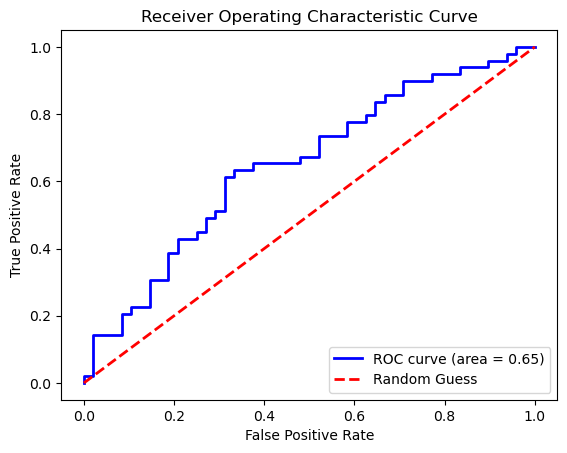

In [158]:
# ROC curve

fpr, tpr, thresholds = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

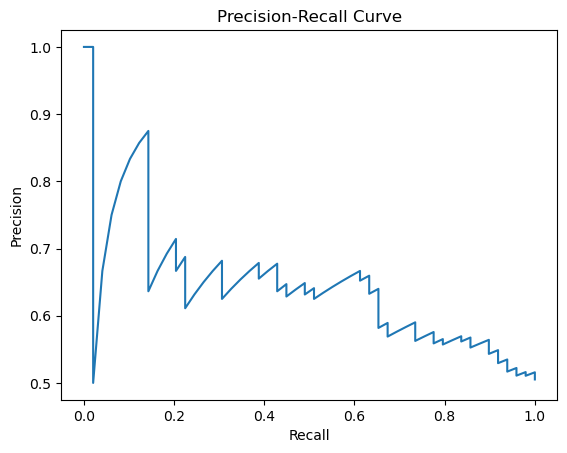

In [159]:
# PR curve

precision, recall, _ = precision_recall_curve(y_test, test_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

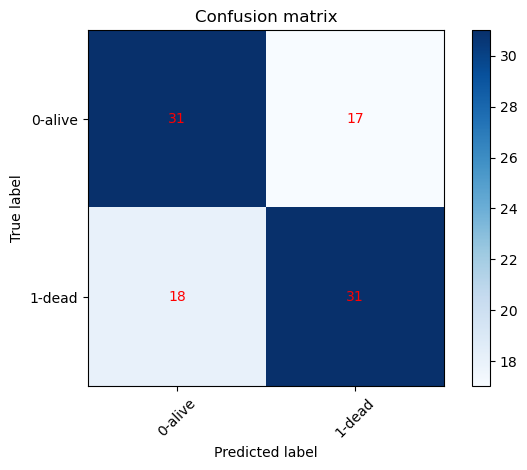

In [164]:
# Confusion matrix

def plot_cm(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    classes = ['0-alive', '1-dead']
    plt.xticks(np.arange(2), classes, rotation=45)
    plt.yticks(np.arange(2), classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_test, test_class)
plot_cm(cm)

In [ ]:
model.save('best_model.h5')

The test accuracy of the classifier for clinical data is 0.6082, which is slightly lower than the multimodal model (0.6391). The multimodal model performs better than single image-based model and clinical data-based model, suggesting that utilizing both data is helpful for a more accurate prediction.

Our full model observed 31 true positives and 31 true negatives, which means it has a balanced performance in correctly identifying both survival and non-survival cases.

On the test set, the full model achieved a precision of 0.64 and a recall of 0.63. The F1 score is 0.64. The area under the receiver operating characteristic curve is 0.65. These results indicate moderate prediction ability. The model correctly predicted most positive cases among all predicted positive cases, and also correctly predicted most positive cases among all actual positive cases. The precision-recall curve shows the model's precision decreases as recall increases, indicating a trade-off between precision and recall.

## Autoencoder <div id='autoencoder'></div>


We want to employ representation learning to the 2D MRI data. After encoding the image data, we can then concatenate clinical data with the flattened or pooled latent space and train another network to perform our prediction task. The model may perform better with additional clinical data.

In [15]:
# Encoder
input_img = Input(shape=(120, 120, 1))
x = layers.Conv2D(32, (4,4), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  
x = layers.Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  
encoder = Model(input_img, encoded)

# Decoder
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x) 
x = layers.Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  
decoded = layers.Conv2D(1, (4, 4), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        8208      
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 3)         435       
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 1)         28        
                                                           

In [19]:
es=keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
autoencoder.fit(X_full,
                X_full,
                batch_size=4,
                validation_split=.2,
                callbacks=es,
                epochs=100)

Epoch 1/100


2024-04-25 01:31:37.787058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-04-25 01:31:37.912621: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-25 01:31:38.404200: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-25 01:31:38.934840: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f60ed53e6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 01:31:38.934884: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-25 01:31:38.940970: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714008699.053689   16918 device_compiler.h:186] Compiled

98/98 [==============================] - 6s 16ms/step - loss: 0.2794 - val_loss: 0.0614
Epoch 2/100
98/98 [==============================] - 1s 6ms/step - loss: 0.0479 - val_loss: 0.0469
Epoch 3/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0416 - val_loss: 0.0450
Epoch 4/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0404 - val_loss: 0.0444
Epoch 5/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0399 - val_loss: 0.0438
Epoch 6/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0394 - val_loss: 0.0434
Epoch 7/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0391 - val_loss: 0.0431
Epoch 8/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0390 - val_loss: 0.0429
Epoch 9/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0388 - val_loss: 0.0432
Epoch 10/100
98/98 [==============================] - 1s 5ms/step - loss: 0.0387 - val_loss: 0.0428
Epoch 11/100
98/98 [

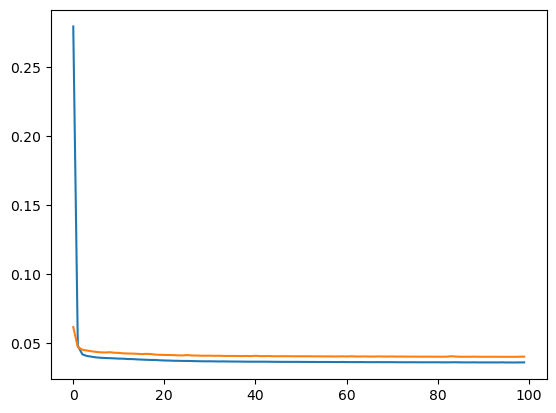

In [20]:
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])

In [21]:
y_pred = autoencoder.predict(X_full)

16/16 [==============================] - 1s 20ms/step


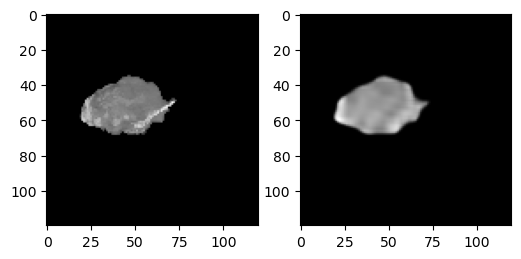

In [22]:
fig, axes = plt.subplots(1,2, figsize=(6,3.5))
idx = 5
axes[0].imshow(X_full[idx], cmap='grey');
axes[1].imshow(y_pred[idx], cmap='grey');

In [23]:
# fix the model's parameters
for layer in autoencoder.layers:
    layer.trainable = False

# use the encoder part 
encoded_x=encoder.predict(X_full)
encoded_x.shape

16/16 [==============================] - 0s 2ms/step


(489, 30, 30, 1)

In [24]:
encoded_x_reshaped=encoded_x.reshape(489,-1)
encoded_x_reshaped.shape

(489, 900)

array([0.14567636, 0.09690156], dtype=float32)

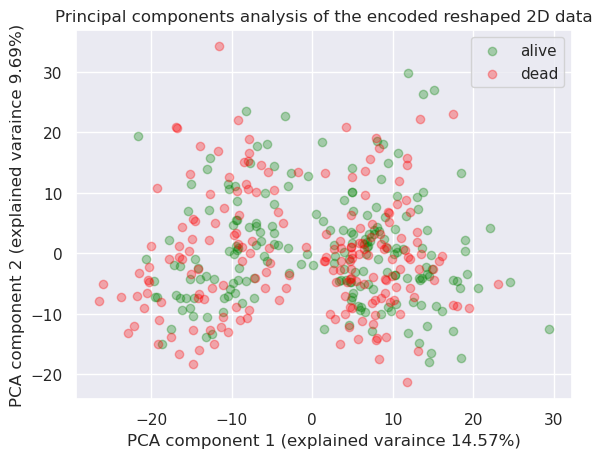

In [25]:
pca_plot(encoded_x_reshaped,"Principal components analysis of the encoded reshaped 2D data")

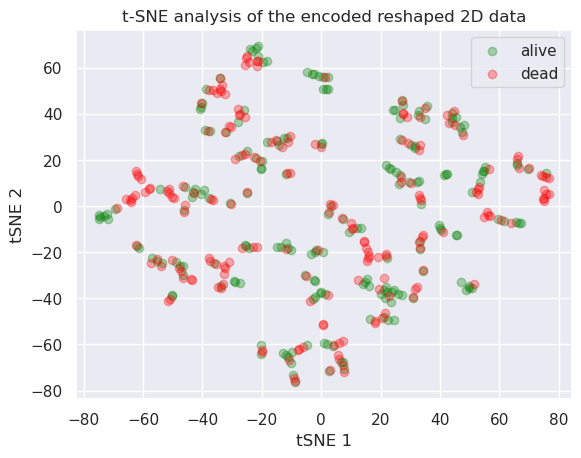

In [127]:
tsne_plot(encoded_x_reshaped,"t-SNE analysis of the encoded reshaped 2D data")

From the PCA and tSNE plots, we do see that the autoencoder extracts the key features of the model. However, we do not see a strong relationship of the dimensional reduced 2D pixels in both original and encoded data and the outcome. Again, same as the EDA part, it is perfectly resonable not to identify distinctions between the survival outcome in only two dimensions, with little variance explained. Relationships between tumor MRI and survival outcome could be more complicated than that. However, autoencoder model is semi-supervised, which does not guarantee relationship with the survival outcome. Given the limited time and the better results demonstrated in other models such as transfer learning, we did not choose the model of AutoEncoder to learn the features in the image. 



###  3D CNN Selection and Justification <div id='3dcnn'></div>

Recap that our image data is in 3 dimensions. Although 2D images could be imputated and processed by 2D CNN, these layers will loss some features along the z-axis (suppose each flatten images are in the X-axis and Y-axis). Therefore, if we want to learn feature representations, 2D convolutional nerual network might work, while we prefer to try using 3D convolutional nerual network as a try. The idea is similar to 2D convolutional neural network, but in our case, the kernels can filter 3D signals. So we will provide two versions of 3D CNN models, one with a very basic structure and the other with some complexities. 

For later integration of features in the clinical data as a whole picture, here we need to first build a 3D CNN model with reasonable (or optimal) prediction accuracy of binary classification and then we expect to integrate clinical data using additional layers as another inputs. Therefore, in this part, evaluation of model relies on the accuracy of binary classification.

In [24]:
#model
def get_model(width=120, height=120, depth=77):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 77, 1   0         
                             )]                                  
                                                                 
 conv3d_4 (Conv3D)           (None, 118, 118, 75, 16   448       
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 59, 59, 37, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 59, 59, 37, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_5 (Conv3D)           (None, 57, 57, 35, 16)    6928  

In [25]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    X_train_image,
    y_train,
    validation_split=0.20,
    batch_size=10,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
32/32 - 10s - loss: 0.6938 - acc: 0.5112 - val_loss: 0.6930 - val_acc: 0.5190 - 10s/epoch - 301ms/step
Epoch 2/50
32/32 - 7s - loss: 0.6722 - acc: 0.5623 - val_loss: 0.6928 - val_acc: 0.5190 - 7s/epoch - 230ms/step
Epoch 3/50
32/32 - 7s - loss: 0.6672 - acc: 0.5879 - val_loss: 0.6936 - val_acc: 0.5190 - 7s/epoch - 226ms/step
Epoch 4/50
32/32 - 7s - loss: 0.6476 - acc: 0.6294 - val_loss: 0.7078 - val_acc: 0.4810 - 7s/epoch - 226ms/step
Epoch 5/50
32/32 - 7s - loss: 0.6305 - acc: 0.6518 - val_loss: 0.7032 - val_acc: 0.5190 - 7s/epoch - 226ms/step
Epoch 6/50
32/32 - 7s - loss: 0.6013 - acc: 0.6741 - val_loss: 0.6906 - val_acc: 0.5190 - 7s/epoch - 230ms/step
Epoch 7/50
32/32 - 7s - loss: 0.5707 - acc: 0.7380 - val_loss: 0.7404 - val_acc: 0.4810 - 7s/epoch - 226ms/step
Epoch 8/50
32/32 - 7s - loss: 0.5442 - acc: 0.7572 - val_loss: 0.8805 - val_acc: 0.4810 - 7s/epoch - 227ms/step
Epoch 9/50
32/32 - 7s - loss: 0.5073 - acc: 0.7540 - val_loss: 1.3189 - val_acc: 0.4810 - 7s/epoch - 2

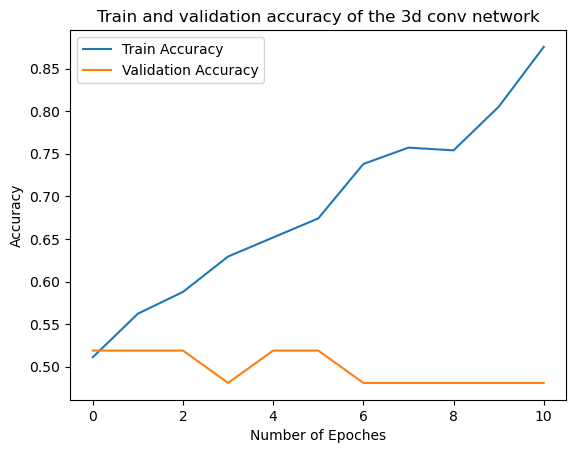

In [26]:
plt.plot(model.history.history["acc"],label="Train Accuracy")
plt.plot(model.history.history["val_acc"],label="Validation Accuracy")
plt.title("Train and validation accuracy of the 3d conv network")
plt.xlabel("Number of Epoches")
plt.ylabel("Accuracy")
plt.legend();


In [27]:
test_acc = model.evaluate(X_test_image, y_test)[1]
test_acc

4/4 [==============================] - 3s 184ms/step - loss: 1.8394 - acc: 0.5052


0.5051546096801758

The accuracy of 3D CNN with the black regions is around 0.5, which is not better than random classification. The plot of training history shows the training accuracy is significantly higher than the validation accuracy, and validation accuracy did not change during training. This suggests the model is overfitting.

#### 3D CNN without the black regions <div id='3dcnn_new'></div>

In previous analyses, we noticed there are a lot of black pixels with 0 values surrounding the tumor. We want to explore whether removing these black regions can improve the model's performance.

In [28]:
number_of_patients=X_train_image.shape[0]

In [29]:
# extract the tumor and remove the black pixels

def crop_image(img):
    position=np.where(img>0)
    d1=np.unique(position[0])
    d2=np.unique(position[1])
    d3=np.unique(position[2])
    cropped_image = img[min(d1):(max(d1)+1), min(d2):(max(d2)+1), min(d3):(max(d3)+1), :]
    return cropped_image

In [30]:
X_train_new = []

for ind in range(number_of_patients):
    temp = X_train_image[ind]
    temp_new = crop_image(temp)
    X_train_new.append(temp_new)

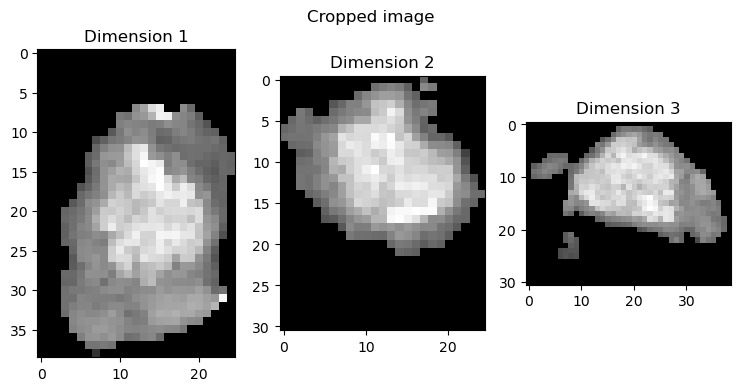

In [34]:
plot_3d_MRI(X_train_new[0],"Cropped image")

In [35]:
# resize the images to the same dimensions

def resize_3D(img, new_width, new_height, new_depth):
    height, width, depth = img.shape[0:3]
    resized_3d_image = np.zeros((new_height, new_width, new_depth), dtype=img.dtype)
    for d in range(new_depth):
        d_orig = int(d * depth / new_depth)
        for h in range(new_height):
            h_orig = int(h * height / new_height)
            for w in range(new_width):
                w_orig = int(w * width / new_width)
                resized_3d_image[h, w, d] = img[h_orig, w_orig, d_orig][0]
    return resized_3d_image

In [36]:
X_train_resized = []

for ind in range(number_of_patients):
    temp = X_train_new[ind]
    temp_new = resize_3D(temp, 60, 60, 38)
    temp_new = np.expand_dims(temp_new,axis=3)
    X_train_resized.append(temp_new)

X_train_resized = np.array(X_train_resized)

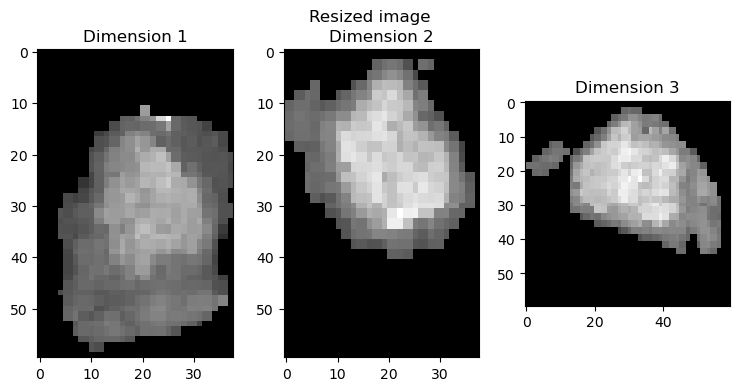

In [37]:
plot_3d_MRI(X_train_resized[0],"Resized image")

In [39]:
from keras.utils import set_random_seed

def get_model(width=120, height=120, depth=77):
    """Build a 3D convolutional neural network model."""
    set_random_seed(109)

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(60, 60, 38)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 60, 38, 1)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 58, 58, 36, 8)     224       
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 29, 29, 18, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 29, 29, 18, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 27, 27, 16, 16)    3472      
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 13, 13, 8, 16)     0     

In [40]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0004),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# Train the model, doing validation at the end of each epoch
epochs = 35
model.fit(
    X_train_resized,
    y_train,
    validation_split=0.20,
    batch_size=16,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/35
20/20 - 4s - loss: 0.7265 - acc: 0.5304 - val_loss: 0.6938 - val_acc: 0.5190 - 4s/epoch - 201ms/step
Epoch 2/35
20/20 - 1s - loss: 0.6882 - acc: 0.5591 - val_loss: 0.6941 - val_acc: 0.5190 - 990ms/epoch - 49ms/step
Epoch 3/35
20/20 - 1s - loss: 0.6826 - acc: 0.5144 - val_loss: 0.6940 - val_acc: 0.5190 - 979ms/epoch - 49ms/step
Epoch 4/35
20/20 - 1s - loss: 0.6626 - acc: 0.6038 - val_loss: 0.6916 - val_acc: 0.5190 - 1s/epoch - 54ms/step
Epoch 5/35
20/20 - 1s - loss: 0.6723 - acc: 0.5623 - val_loss: 0.6908 - val_acc: 0.5570 - 1s/epoch - 54ms/step
Epoch 6/35
20/20 - 1s - loss: 0.6485 - acc: 0.6166 - val_loss: 0.6875 - val_acc: 0.5190 - 1s/epoch - 53ms/step
Epoch 7/35
20/20 - 1s - loss: 0.6628 - acc: 0.6390 - val_loss: 0.6888 - val_acc: 0.5190 - 973ms/epoch - 49ms/step
Epoch 8/35
20/20 - 1s - loss: 0.6518 - acc: 0.6326 - val_loss: 0.6918 - val_acc: 0.5190 - 977ms/epoch - 49ms/step
Epoch 9/35
20/20 - 1s - loss: 0.6427 - acc: 0.6677 - val_loss: 0.6859 - val_acc: 0.4937 - 1s/epoch 

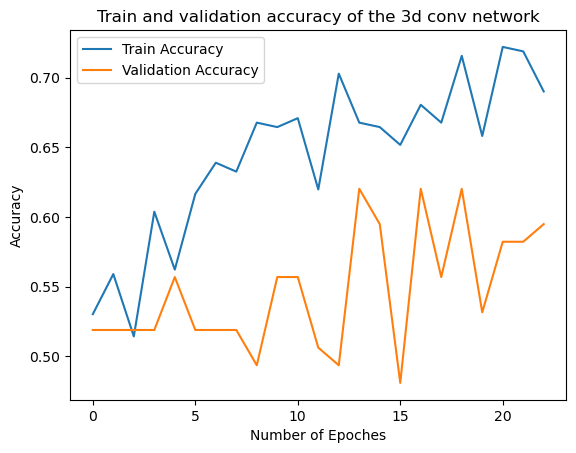

In [42]:
plt.plot(model.history.history["acc"],label="Train Accuracy")
plt.plot(model.history.history["val_acc"],label="Validation Accuracy")
plt.title("Train and validation accuracy of the 3d conv network")
plt.xlabel("Number of Epoches")
plt.ylabel("Accuracy")
plt.legend();

In [43]:
number_of_patients_test=X_test_image.shape[0]
X_test_new = []

for ind in range(number_of_patients_test):
    temp = X_test_image[ind]
    temp_new = crop_image(temp)
    X_test_new.append(temp_new)

X_test_resized = []

for ind in range(number_of_patients_test):
    temp = X_test_new[ind]
    temp_new = resize_3D(temp, 60, 60, 38)
    temp_new = np.expand_dims(temp_new,axis=3)
    X_test_resized.append(temp_new)

X_test_resized = np.array(X_test_resized)

In [44]:
test_acc = model.evaluate(X_test_resized, y_test)[1]
test_acc

4/4 [==============================] - 0s 33ms/step - loss: 0.6724 - acc: 0.5670


0.5670102834701538

For 3D CNN trained without the black pixels of the images, the accuracy slightly improved, which is 0.57. The accuracy without black regions is slightly higher than with black regions, which means removing black pixels may contribute to better model performance. However, the plot of training history shows the model still overfits. 

In conclusion, 3D CNN models are not better than 2D CNN models. 3D CNN models also have a high risk of overfitting.

[back](#content)

## Part 5. Final Model and Discussion<div id='part5'>

### Flow Chart of our model<div id='flow_chart'></div>
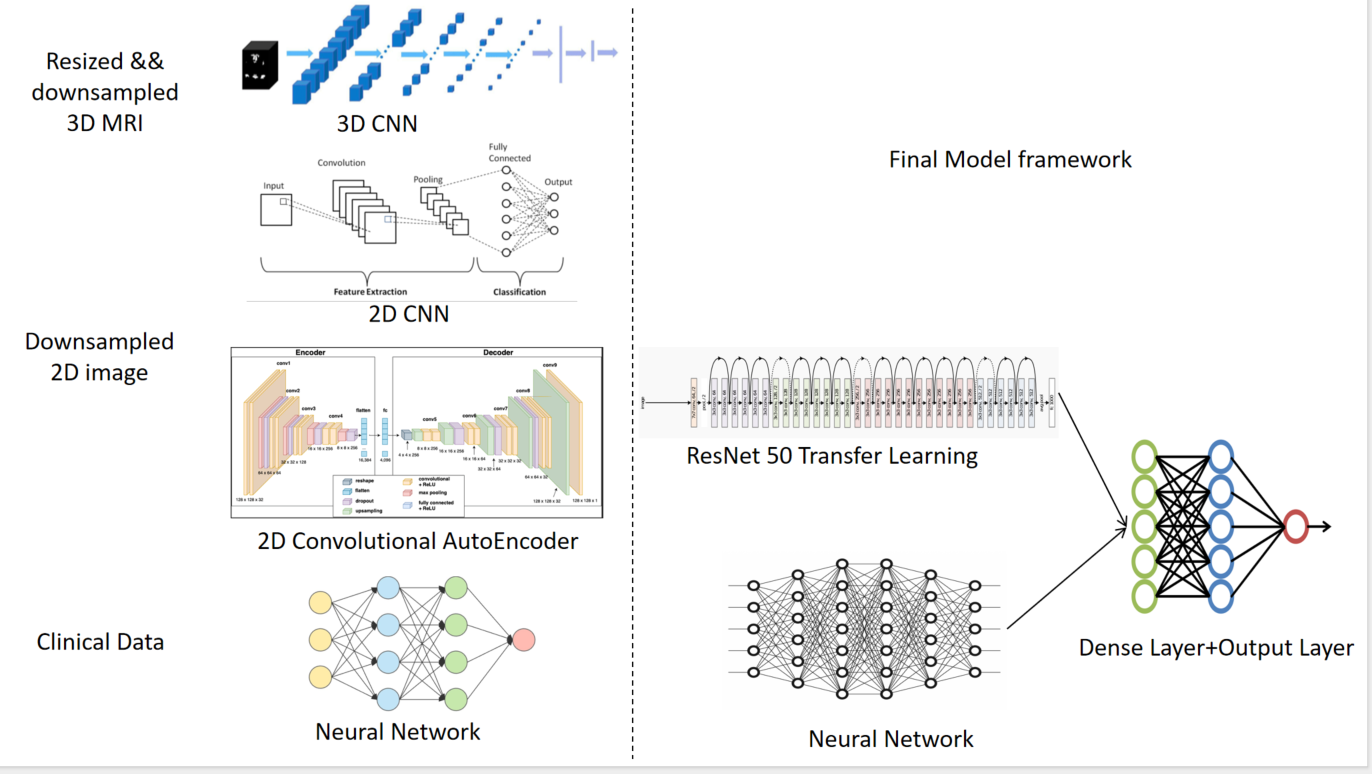

### Steps for our final model<div id='steps'></div>
#### Data preprocessing
##### Steps(+ considerations)
1) Relying on the tumor-segmented results, we masked non-tumor regions in the T2-weighted MRI image to carve out only the tumor regions.
2) Then we performed 3D max-pooling for the original 240 * 240 * 155 image data, and reduced it into 120 * 120 * 77 dimension, which really to save the memory space needed and the computation costs.
3) We normalized the downsampled 3D MRI image, scaling all voxels in the range of [0,1].(Our initial 3D convolutional neural network classifier is based on this preprocessed data. However, it still requires huge memory and computation resources to train a powerful enough 3D convolutional classifier. Therefore, we decided to further downsample the data and make it 2D in order to achieve successful model training)
4) We did maxpooling in the third dimension, which is to use the maximal voxel values along the third dimension for each (x,y) position in the first and second dimension. The resultant 2d images are 120 * 120 in size.

##### Assumptions:
1) The survival-related(outcome of interest) information in the 3D MRI image is retained after we downsampled the original image into 120 * 120.

#### Models
##### Steps
1) First try (2D CNN): This model is just a CNN model with 4 convolutional layers and 4 fully connected layers. The number of layers are quite small because of the limited computational resources. We added batch normalization, dropout and L1, L2 regularization to improve the model performance. The validation accuracy of this model is 0.6456 and the test accuracy is 0.5258.
2) Second try (Transfer 2D ResNet50): In order to reduce training time and computational resources, we decide to utilize pre-trained ResNet50 to perfrom our classification task. The ResNet50 is promising because it is a lot more expressive with deeper layers than our own 2D CNN model that is trained from scratches. We performed fine-tuning in our dataset to do the survival classification task. The model demonstrated a test accuracy of 0.6082.
3) Third try (Convolution AutoEncoder): Using autoencoder, we aim to learn a low-dimension respresentation of the MRI imageFrom the PCA and tSNE plots, we do see that the autoencoder extracts the key features of the model. However, since semi-supervised Convolution AutoEncoder did not guarantee that the learned represenation has a relationship with the survival outcome. Given the limited time and better performance demonstrated by this model, we did not choose this model as our final model.
4) Fourth try (3D Convolution neural network classifier): We would like to perform classification using features from 3D MRI image. In this way, we believe we will capture the most abundant information compared with 2D. However, the training time and computation resources are a huge concern, which causes our model's performance to be not very ideal.
5) **Final model: Multimodal modelling, which accepts both image and clincial data as input, will be our final model given the EDA results and the model performance observed.** The key idea is that we want to take advantage of the predictive power of both image and clinical data. We will use transfer learning to train the model that takes 2D image as the input, and then combine it with a clinical data model, further adding some layers to perform classification task. In this way, we might be able to take advantage of the high performance of our transfer learning model. The model demonstrated a test accuracy of 0.6391, which is the highest test accuracy we have achieved.

##### Assumption in final model:

1) The high performance demonstrated in ResNet50 transfering learning could be inherited into the combined model.
2) The spatial information in the 2D MRI is already enough to study the relationship between the MRI image and the survival outcome.
3) Clinical data would help to improve survival prediction (which is kind of proved in our PCA plot in EDA section)

#### Parameter choices and tuning considerations
1) Regularization: We used l1,l2 regularization and dropout to prevent overfitting.
2) Batch size, learning rate, number of epcohs, optimizer: We prefer to use Adam Optimizer here. We tuned Batch size and learning rate accordingly, and used earlystopping to prevent overfitting.


#### Evaluation
1) Accuracy: Accuracy can measure the proportion of correctly classified instances out of the total instances.
2) F1-score: The F1-score is the harmonic mean of precision and recall.It considers both false positives and false negatives.
3) Precision: Precision measures the proportion of true positive predictions out of all positive predictions. It's valuable when the cost of false positives is high.
4) Specificity: Specificity measures the proportion of actual negatives that are correctly identified. It's particularly important in situations where correctly identifying negatives is crucial.
5) AUC: AUC gives an aggregate measure of performance across all possible classification thresholds. A higher AUC indicates better overall model performance.

### Conclusion<div id='conclusion'></div>

To address the research question of predicting patient mortality based on their 3D MRI images and corresponding clinical data (mainly for epigenetic information), we have proposed three model types: a 2D CNN model incorporating transfer learning, a 3D CNN model, and an autoencoder. By evaluating the three types of models, we finalized our model as a 2D CNN multimodal model including transfer learning of ResNet50 for extraction of the image features and fully connected networks for extraction of the clinical data features. We achieved a test accuracy of 0.6391 for this model, which is better than only using images or clinical data as input.

### Discussion<div id='discussion'></div>
#### Strengths

Our model has the following strengths:

1) It has a complex nature. ResNet50 has over 20 million parameters and a very deep structure. By utilizing transfer learning, we saved a lot of computational resources and achieved an ideal result.
2) It combines MRI image data and clinical data. Image data mainly contains information about the shape, size and other characteristics of the tumor, while clinical data contains information about demographics, genetic and epigenetic states of patients. By combining different types of data, the will be more information for the classification task, and thus the model performs better than only using a single input as predictors.

#### Limitations

Our model has the following limitations:

1) Loss of spacial information: By applying tumor segmentation techniques, although the tumor part is purified from the whole brain, the spacial information of the tumor (i.e. at which part of the brain) is also removed since we simply masked the surrounding regions with black voxels (i.e. value=0);
2) Computational Constraint: Due to limited computational resources, we performed downsampling of the original data and did not build a deep 3D CNN model which is supposed to be more powerful than 2D CNN deep learning models;
3) Model interpretability is a great challenge, especially for the spacial features of the tumor.

#### Future Direction
We currently presented the results from the transfer learning approach using the 2D CNN model. The implementation of the 3D CNN model and the autoencoder are feasible, provided sufficient time and computational resources are available, while not for the final results of this project. Moving forward, one of our primary future directions is to implement 3D CNN model and autoencoder with two pathways of integrating 3D MRI images and clinical data. Integrating clinical data into 3D CNN model would be similar with 2D CNN model. While we could combine embeddings of images and clinical data from two decoders to an encoder for the prediction. Also, we may also extract learned representations of 3D MRI images from 3D CNN model and then integrate them with embeddings of clinical data from a decoder for a final classifier. 

In regards to the data itself, preliminary EDA suggests that there might be a minor correlation between the MRI images and mortality status. This observed correlation could be due to various underlying factors, such as the presence of specific patterns within the MRI images that are subtly indicative of mortality risk. Further investigation into these correlations, through more detailed image analysis and the integration of more granular clinical data, might enhance our understanding and improve the accuracy of our predictions. This insight could potentially lead to the development of more refined models that better capture the complexities of the data to yield more reliable predictions.

[back](#content)